### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve

import scorecardpy as sc

from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

### Funciones

In [2]:
def oversampling_by_smote(X,y,sampling_strategy='auto',random_state=186,k_neighbors=5,n_jobs=None,m_neighbors=10,kind="borderline-1"):
    sampler = BorderlineSMOTE(sampling_strategy=sampling_strategy,random_state=random_state,k_neighbors=k_neighbors,n_jobs=n_jobs,m_neighbors=m_neighbors,kind=kind)
    X_res, y_res = sampler.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res,y_res

In [3]:
## Score Distribution ##
def plot_score_distribution(score1,score2,label1,label2,title):
    sns.distplot(score1, color="darkturquoise", label=label1)
    sns.distplot(score2, color="tomato", label=label2)
    plt.legend(labels=[label1, label2])
    plt.title(title)
    plt.show()

In [4]:
## Show Score Bin sorting ##
def score_bin_sort(score, label=None, title=None, x_limits=None, x_tick_break=50, seed=186):
    # inputs checking
    ## score
    if not isinstance(score, dict) and len(score) != 2:
        raise Exception("Incorrect inputs; score should be a dictionary with two elements.")
    else:
        if any([not isinstance(i, pd.DataFrame) for i in score.values()]):
            raise Exception("Incorrect inputs; score is a dictionary of two dataframes.")
        score_columns = [list(i.columns) for i in score.values()]
        if set(score_columns[0]) != set(score_columns[1]):
            raise Exception("Incorrect inputs; the column names of two dataframes in score should be the same.")
    ## label
    if label is not None:
        if not isinstance(label, dict) and len(label) != 2:
            raise Exception("Incorrect inputs; label should be a dictionary with two elements.")
        else:
            if set(score.keys()) != set(label.keys()):
                raise Exception("Incorrect inputs; the keys of score and label should be the same. ")
            for i in label.keys():
                if isinstance(label[i], pd.DataFrame):
                    if len(label[i].columns) == 1:
                        label[i] = label[i].iloc[:,0]
                    else:
                        raise Exception("Incorrect inputs; the number of columns in label should be 1.")
    # score dataframe column names
    score_names = score[list(score.keys())[0]].columns
    # merge label with score
    for i in score.keys():
        score[i] = score[i].copy(deep=True)
        if label is not None:
            score[i].loc[:,'y'] = label[i]
        else:
            score[i].copy(deep=True).loc[:,'y'] = np.nan
    # dateset of score and label
    dt_sl = pd.concat(score, names=['ae', 'rowid']).reset_index()\
      .sample(frac=1, random_state=seed)
      # ae refers to 'Actual & Expected'
    
    # PSI function
    def psi(dat):
        dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
          .pivot_table(values='N', index='bin', columns='ae').fillna(0.9)\
          .agg(lambda x: x/sum(x))
        dt_bae.columns = ['A','E']
        psi_dt = dt_bae.assign(
          AE = lambda x: x.A-x.E,
          logAE = lambda x: np.log(x.A/x.E)
        ).assign(
          bin_PSI=lambda x: x.AE*x.logAE
        )['bin_PSI'].sum()
        return psi_dt
    
    # return psi and pic
    rt_psi = {}
    rt_pic = {}
    rt_dat = {}
    rt = {}
    for sn in score_names:
        # dataframe with columns of ae y sn
        dat = dt_sl[['ae', 'y', sn]]
        if len(dt_sl[sn].unique()) > 10:
            # breakpoints
            if x_limits is None:
                x_limits = dat[sn].quantile([0.02, 0.98])
                x_limits = round(x_limits/x_tick_break)*x_tick_break
                x_limits = list(x_limits)
        
            brkp = np.unique([np.floor(min(dt_sl[sn])/x_tick_break)*x_tick_break]+\
              list(np.arange(x_limits[0], x_limits[1], x_tick_break))+\
              [np.ceil(max(dt_sl[sn])/x_tick_break)*x_tick_break])
            # cut
            labels = ['[{},{})'.format(int(brkp[i]), int(brkp[i+1])) for i in range(len(brkp)-1)]
            dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
        else:
            dat.loc[:,'bin'] = dat[sn]
        # psi ------
        rt_psi[sn] = pd.DataFrame({'PSI':psi(dat)},index=np.arange(1)) 
    
        # distribution of scorecard probability
        def good(x): return sum(x==0)
        def bad(x): return sum(x==1)
        distr_prob = dat.groupby(['ae', 'bin'])\
          ['y'].agg([good, bad])\
          .assign(N=lambda x: x.good+x.bad,
            badprob=lambda x: x.bad/(x.good+x.bad)
          ).reset_index()
        distr_prob.loc[:,'distr'] = distr_prob.groupby('ae')['N'].transform(lambda x:x/sum(x))
        # pivot table
        distr_prob = distr_prob.pivot_table(values=['N','badprob', 'distr'], index='bin', columns='ae')
        rt_dat[sn] = distr_prob[['N','badprob']].reset_index()
        score_bin_sort = pd.DataFrame()
        score_bin_sort['score'] = rt_dat[sn]['bin']
        score_bin_sort['total'] = rt_dat[sn][('N','test')]+rt_dat[sn][('N','train')]
        score_bin_sort['good'] = (rt_dat[sn][('N','test')]*(1-rt_dat[sn][('badprob','test')])+rt_dat[sn][('N','train')]*(1-rt_dat[sn][('badprob','train')])).map(lambda x: int(x))
        score_bin_sort['bad'] = (rt_dat[sn][('N','test')]*rt_dat[sn][('badprob','test')]+rt_dat[sn][('N','train')]*rt_dat[sn][('badprob','train')]).map(lambda x: int(x))
        score_bin_sort['bad rate%'] = (score_bin_sort['bad']/score_bin_sort['total']*100).map(lambda x: int(x))
        score_bin_sort['bin'] = score_bin_sort.index.values
        score_bin_sort = score_bin_sort[['bin','score','total','good','bad','bad rate%']]
    return score_bin_sort

In [5]:
def replace_nulls_with_median_auto(df):
    """
    Replaces null values in numeric columns of a DataFrame with the median of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with null values replaced by median in numeric columns.
    """
    numeric_columns = df.select_dtypes(include='number').columns
    
    for column in numeric_columns:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)
    
    #return df

In [6]:
def replace_nulls_with_mode_auto(df):
    """
    Replaces null values in categorical columns of a DataFrame with the mode of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with null values replaced by mode in categorical columns.
    """
    categorical_columns = df.select_dtypes(include='object').columns
    
    for column in categorical_columns:
        mode_value = df[column].mode()[0]  # mode() returns a Series, take the first mode value
        df[column].fillna(mode_value, inplace=True)
    
    #return df

In [7]:
def get_column_types(df):
    """
    Returns two lists: one with the names of categorical columns and another with the names of numeric columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A tuple containing two lists - (categorical_columns, numeric_columns).
    """
    categorical_columns = df.select_dtypes(include='object').columns.tolist()
    numeric_columns = df.select_dtypes(include='number').columns.tolist()
    
    return categorical_columns, numeric_columns

In [8]:
def reemplazar_outliers_percentil_95(df):
    # Seleccionar solo las columnas numéricas
    columnas_numericas = df.select_dtypes(include=['number']).columns
    
    # Iterar sobre cada columna numérica
    for columna in columnas_numericas:
        # Calcular el percentil 95
        percentil_95 = df[columna].quantile(0.95)
        
        # Reemplazar los valores mayores al percentil 95 por el valor del percentil 95
        df[columna] = df[columna].apply(lambda x: percentil_95 if x > percentil_95 else x)
    
    #return df

In [9]:
def inspeccionar_valores_nulos(df):
    # Inspección de valores nulos
    nulos = pd.DataFrame(df.isna().sum().reset_index())
    nulos = nulos.rename(columns={"index": "Variable", 0: "Nulos"})
    
    # Calcular el porcentaje de nulos
    nulos['Porcentaje Nulos'] = (nulos['Nulos'] / len(df)) * 100
    
    # Ordenar por número de nulos en orden descendente
    nulos = nulos.sort_values(by='Nulos', ascending=False)
    
    # Mostrar el resultado
    #print(nulos)
    
    return nulos

#### Importando datos de entrenamiento

In [10]:
datos = pd.read_csv("application_train.csv", engine='c')

In [11]:
#copia de los datos originales
df = datos.copy()

In [12]:
#Vistazo a los datos
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                       0.00                      0.00   
1                       0.00                      0.00   
2                       0.00                      0.00   
3                        NaN                       NaN   
4                       0.00                      0.00   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.00                       0.00   
1                        0.00                       0.00   
2                        0.00                       0.00   
3                         NaN                        NaN   
4                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                       0.00                        1.00  
1                       0.00                        0.00  
2                       0.00                        0.00  
3                        NaN                         NaN  
4                       0.00                        0.00  

[5 rows x 122 columns]

In [13]:
#Estructura del df
df.shape

(307511, 122)

In [14]:
# Seleccionar las columnas que contienen solo 1 y 0
cols_to_convert = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Reemplazar 0 con 'N' y 1 con 'Y', luego convertir a categórico
df[cols_to_convert] = df[cols_to_convert].replace({0: 'N', 1: 'Y'}).astype('object')

In [15]:
#inspección de valores nulos
nulos = pd.DataFrame(df.isna().sum().reset_index())
nulos = nulos.rename(columns={"index": "Variable", 0: "Nulos"})# Calcular el porcentaje de nulos
nulos['Porcentaje Nulos'] = (nulos['Nulos'] / len(df)) * 100
nulos=nulos.sort_values(by='Nulos',ascending=False)
print(nulos)

                         Variable   Nulos  Porcentaje Nulos
76                COMMONAREA_MEDI  214865             69.87
48                 COMMONAREA_AVG  214865             69.87
62                COMMONAREA_MODE  214865             69.87
70       NONLIVINGAPARTMENTS_MODE  213514             69.43
56        NONLIVINGAPARTMENTS_AVG  213514             69.43
84       NONLIVINGAPARTMENTS_MEDI  213514             69.43
86             FONDKAPREMONT_MODE  210295             68.39
68          LIVINGAPARTMENTS_MODE  210199             68.35
54           LIVINGAPARTMENTS_AVG  210199             68.35
82          LIVINGAPARTMENTS_MEDI  210199             68.35
52                  FLOORSMIN_AVG  208642             67.85
66                 FLOORSMIN_MODE  208642             67.85
80                 FLOORSMIN_MEDI  208642             67.85
75               YEARS_BUILD_MEDI  204488             66.50
61               YEARS_BUILD_MODE  204488             66.50
47                YEARS_BUILD_AVG  20448

In [16]:
#eliminacion de variables con nulos sobre el 60%
eliminar_cols=list(nulos[nulos['Porcentaje Nulos']>=60].Variable)
df.drop(eliminar_cols,axis=1,inplace=True)

In [17]:
#inspección de valores nulos
nulos = pd.DataFrame(df.isna().sum().reset_index())
nulos = nulos.rename(columns={"index": "Variable", 0: "Nulos"})# Calcular el porcentaje de nulos
nulos['Porcentaje Nulos'] = (nulos['Nulos'] / len(df)) * 100
nulos=nulos.sort_values(by='Nulos',ascending=False)
print(nulos)

                         Variable   Nulos  Porcentaje Nulos
49                   LANDAREA_AVG  182590             59.38
58                  LANDAREA_MODE  182590             59.38
67                  LANDAREA_MEDI  182590             59.38
44               BASEMENTAREA_AVG  179943             58.52
53              BASEMENTAREA_MODE  179943             58.52
62              BASEMENTAREA_MEDI  179943             58.52
40                   EXT_SOURCE_1  173378             56.38
51              NONLIVINGAREA_AVG  169682             55.18
69             NONLIVINGAREA_MEDI  169682             55.18
60             NONLIVINGAREA_MODE  169682             55.18
64                 ELEVATORS_MEDI  163891             53.30
46                  ELEVATORS_AVG  163891             53.30
55                 ELEVATORS_MODE  163891             53.30
72             WALLSMATERIAL_MODE  156341             50.84
52                APARTMENTS_MODE  156061             50.75
43                 APARTMENTS_AVG  15606

In [18]:
#listas con variables numericas y categoricas
categorical_columns, numeric_columns = get_column_types(df)

In [19]:
#elimino de la lista el ID del prestamo
numeric_columns.remove('SK_ID_CURR')
#elimino de la lista la variable dependiente
categorical_columns.remove('TARGET')

In [20]:
#reemplazo de valors nulos de variables numericas por mediana y moda
replace_nulls_with_median_auto(df)

In [21]:
#reemplazo de valors nulos de variables categoricas por moda
replace_nulls_with_mode_auto(df)

In [22]:
#inspección de valores nulos
nulos = pd.DataFrame(df.isna().sum().reset_index())
nulos = nulos.rename(columns={"index": "Variable", 0: "Nulos"})# Calcular el porcentaje de nulos
nulos['Porcentaje Nulos'] = (nulos['Nulos'] / len(df)) * 100
nulos=nulos.sort_values(by='Nulos',ascending=False)
print(nulos)

                         Variable  Nulos  Porcentaje Nulos
0                      SK_ID_CURR      0              0.00
53              BASEMENTAREA_MODE      0              0.00
77       DEF_60_CNT_SOCIAL_CIRCLE      0              0.00
76       OBS_60_CNT_SOCIAL_CIRCLE      0              0.00
75       DEF_30_CNT_SOCIAL_CIRCLE      0              0.00
74       OBS_30_CNT_SOCIAL_CIRCLE      0              0.00
73            EMERGENCYSTATE_MODE      0              0.00
72             WALLSMATERIAL_MODE      0              0.00
71                 TOTALAREA_MODE      0              0.00
70                 HOUSETYPE_MODE      0              0.00
69             NONLIVINGAREA_MEDI      0              0.00
68                LIVINGAREA_MEDI      0              0.00
67                  LANDAREA_MEDI      0              0.00
66                 FLOORSMAX_MEDI      0              0.00
65                 ENTRANCES_MEDI      0              0.00
64                 ELEVATORS_MEDI      0              0.

In [23]:
df.head()

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002      Y         Cash loans           M            N   
1      100003      N         Cash loans           F            N   
2      100004      N    Revolving loans           M            Y   
3      100006      N         Cash loans           F            N   
4      100007      N         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 N                N                N                N   
1  ...                 N                N                N                N   
2  ...                 N                N                N                N   
3  ...                 N                N                N                N   
4  ...                 N                N                N                N   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                       0.00                      0.00   
1                       0.00                      0.00   
2                       0.00                      0.00   
3                       0.00                      0.00   
4                       0.00                      0.00   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.00                       0.00   
1                        0.00                       0.00   
2                        0.00                       0.00   
3                        0.00                       0.00   
4                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                       0.00                        1.00  
1                       0.00                        0.00  
2                       0.00                        0.00  
3                       0.00                        1.00  
4                       0.00                        0.00  

[5 rows x 105 columns]

### EDA

In [24]:
#Principales estadisticas del df
df.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count   307511.00     307511.00         307511.00   307511.00    307511.00   
mean    278180.52          0.42         168797.92   599026.00     27108.49   
std     102790.18          0.72         237123.15   402490.78     14493.46   
min     100002.00          0.00          25650.00    45000.00      1615.50   
25%     189145.50          0.00         112500.00   270000.00     16524.00   
50%     278202.00          0.00         147150.00   513531.00     24903.00   
75%     367142.50          1.00         202500.00   808650.00     34596.00   
max     456255.00         19.00      117000000.00  4050000.00    258025.50   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count        307511.00                   307511.00   307511.00      307511.00   
mean         538316.29                        0.02   -16037.00       63815.05   
std          369288.98                        0.01     4363.99      141275.77   
min           40500.00                        0.00   -25229.00      -17912.00   
25%          238500.00                        0.01   -19682.00       -2760.00   
50%          450000.00                        0.02   -15750.00       -1213.00   
75%          679500.00                        0.03   -12413.00        -289.00   
max         4050000.00                        0.07    -7489.00      365243.00   

       DAYS_REGISTRATION  ...  DEF_30_CNT_SOCIAL_CIRCLE  \
count          307511.00  ...                 307511.00   
mean            -4986.12  ...                      0.14   
std              3522.89  ...                      0.45   
min            -24672.00  ...                      0.00   
25%             -7479.50  ...                      0.00   
50%             -4504.00  ...                      0.00   
75%             -2010.00  ...                      0.00   
max                 0.00  ...                     34.00   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count                 307511.00                 307511.00   
mean                       1.40                      0.10   
std                        2.38                      0.36   
min                        0.00                      0.00   
25%                        0.00                      0.00   
50%                        0.00                      0.00   
75%                        2.00                      0.00   
max                      344.00                     24.00   

       DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
count               307511.00                   307511.00   
mean                  -962.86                        0.01   
std                    826.81                        0.08   
min                  -4292.00                        0.00   
25%                  -1570.00                        0.00   
50%                   -757.00                        0.00   
75%                   -274.00                        0.00   
max                      0.00                        4.00   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count                  307511.00                   307511.00   
mean                        0.01                        0.03   
std                         0.10                        0.19   
min                         0.00                        0.00   
25%                         0.00                        0.00   
50%                         0.00                        0.00   
75%                         0.00                        0.00   
max                         9.00                        8.00   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count                  307511.00                  307511.00   
mean                        0.23                       0.23   
std                         0.86                       0.74   
min                         0.00                       0.00   
25%                         0.00                  

In [25]:
df['TARGET'] = df['TARGET'].replace({'N':0, 'Y':1}).astype('int')

In [26]:
#distribucion de la variable default
df.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

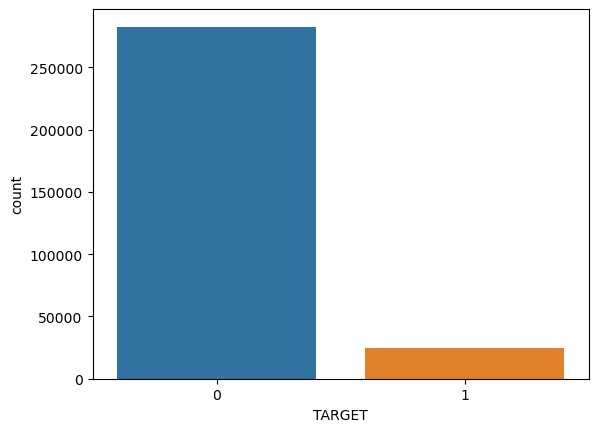

In [27]:
sns.countplot(x="TARGET", data=df)
plt.show()

#### Poporción de defaults en el dataset

In [28]:
media_default=df.TARGET.mean().round(4)
media_default

0.0807

#### Proporción de default por cada variable categórica

In [29]:
#len(categorical_columns)

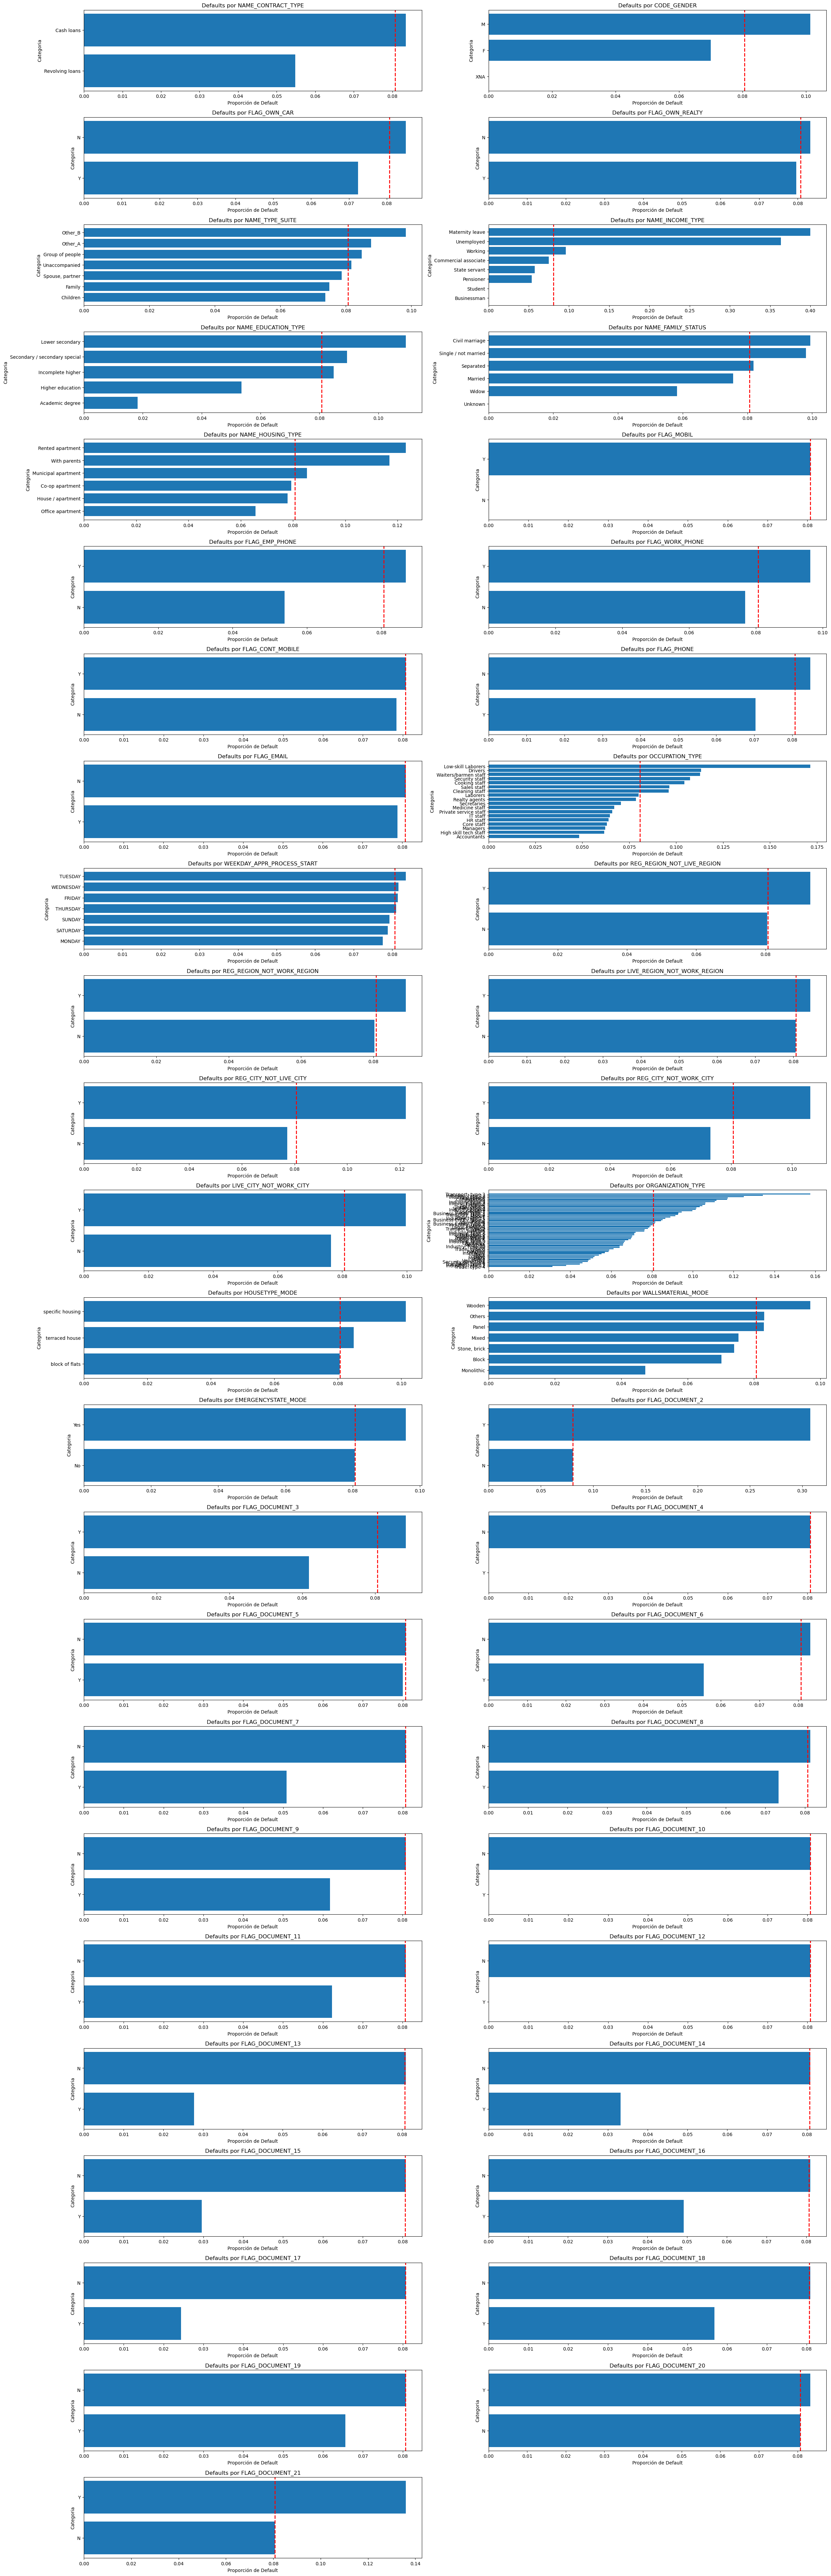

In [30]:
fig, axes = plt.subplots(25, 2, figsize=(25,80))  # 4 filas y 2 columnas

for i, category in enumerate(categorical_columns):
    if i >= len(axes.flatten()):
        break
    ax = axes.flatten()[i]
    grouped_data = df.groupby(category)['TARGET'].mean().sort_values(ascending=True)
    ax.barh(grouped_data.index, grouped_data.values)
    ax.set_xlabel('Proporción de Default')
    ax.set_ylabel('Categoria')
    ax.set_title(f'Defaults por {category}')
    
        # Agregar la línea del promedio
    ax.axvline(media_default, color='red', linestyle='--', linewidth=2, label=f'Prom.: {media_default:.2f}')

# Eliminar los gráficos vacíos si hay menos de 8 categorías
if len(categorical_columns) < len(axes.flatten()):
    for j in range(len(categorical_columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### Matriz de correlación variables independientes

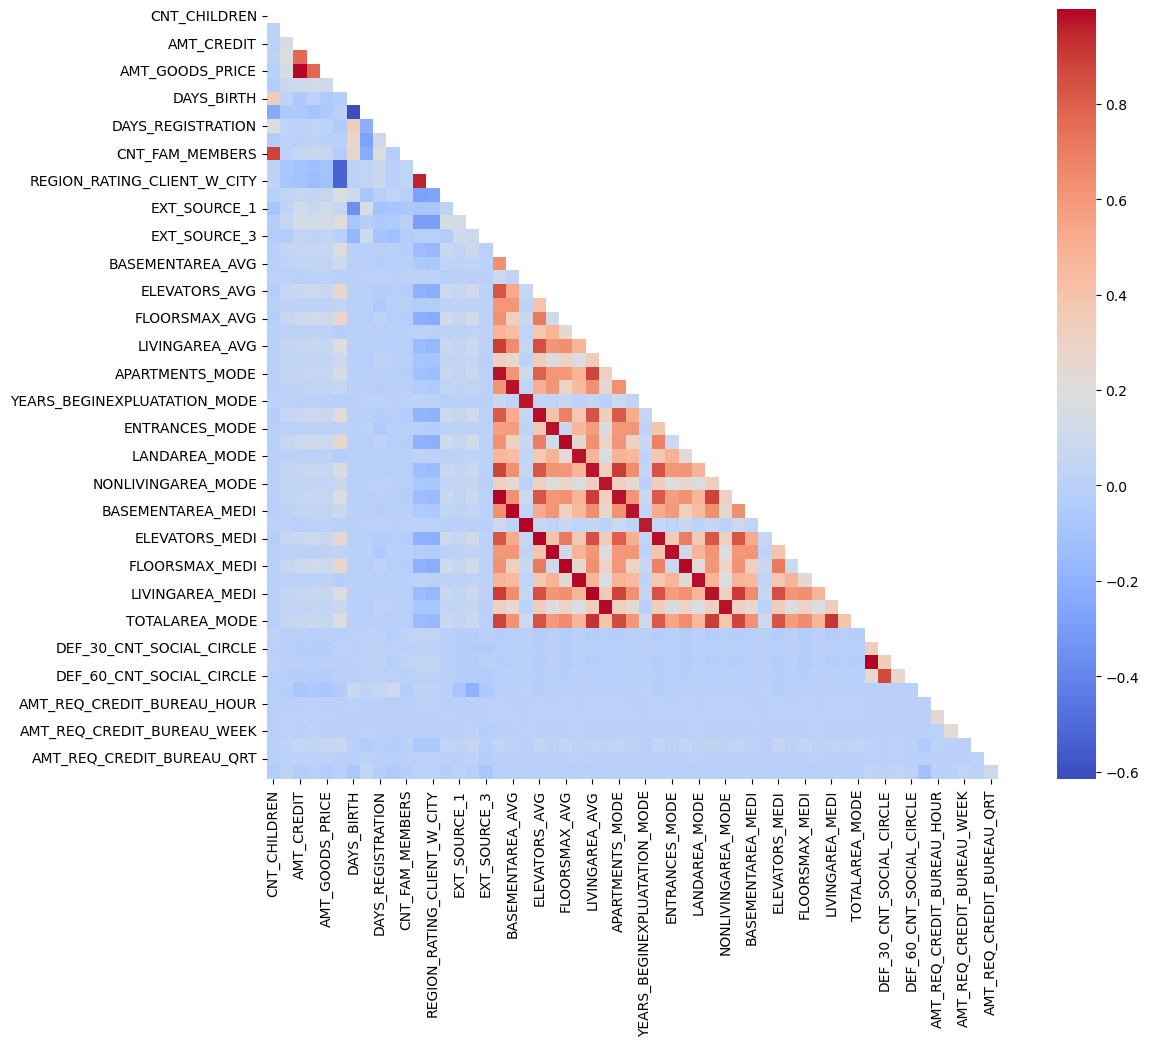

In [31]:
plt.figure(figsize= (12,10))
correlaciones = df[numeric_columns].corr()
upp_mat = np.triu(correlaciones)
sns.heatmap(correlaciones, annot = True, cmap = 'coolwarm', mask = upp_mat,annot_kws={"size": 2})
plt.show()

#### VIF variables independientes para buscar multicolinealidad

In [33]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df[numeric_columns].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df[numeric_columns].values, i) 
                          for i in range(len(df[numeric_columns].columns))] 
  
print(vif_data)

                         feature      VIF
0                   CNT_CHILDREN     6.18
1               AMT_INCOME_TOTAL     1.58
2                     AMT_CREDIT   123.59
3                    AMT_ANNUITY    11.65
4                AMT_GOODS_PRICE   122.67
5     REGION_POPULATION_RELATIVE     4.80
6                     DAYS_BIRTH    31.17
7                  DAYS_EMPLOYED     2.07
8              DAYS_REGISTRATION     3.48
9                DAYS_ID_PUBLISH     5.61
10               CNT_FAM_MEMBERS    29.45
11          REGION_RATING_CLIENT   185.48
12   REGION_RATING_CLIENT_W_CITY   184.63
13       HOUR_APPR_PROCESS_START    15.77
14                  EXT_SOURCE_1    16.73
15                  EXT_SOURCE_2     9.76
16                  EXT_SOURCE_3    10.26
17                APARTMENTS_AVG   468.97
18              BASEMENTAREA_AVG   343.55
19   YEARS_BEGINEXPLUATATION_AVG 54516.61
20                 ELEVATORS_AVG   319.23
21                 ENTRANCES_AVG  1315.62
22                 FLOORSMAX_AVG  

##### Hay harta correlacion entre las variables que terminan con "MODE", "AVG" y "MEDI" ya que describen las mismas características


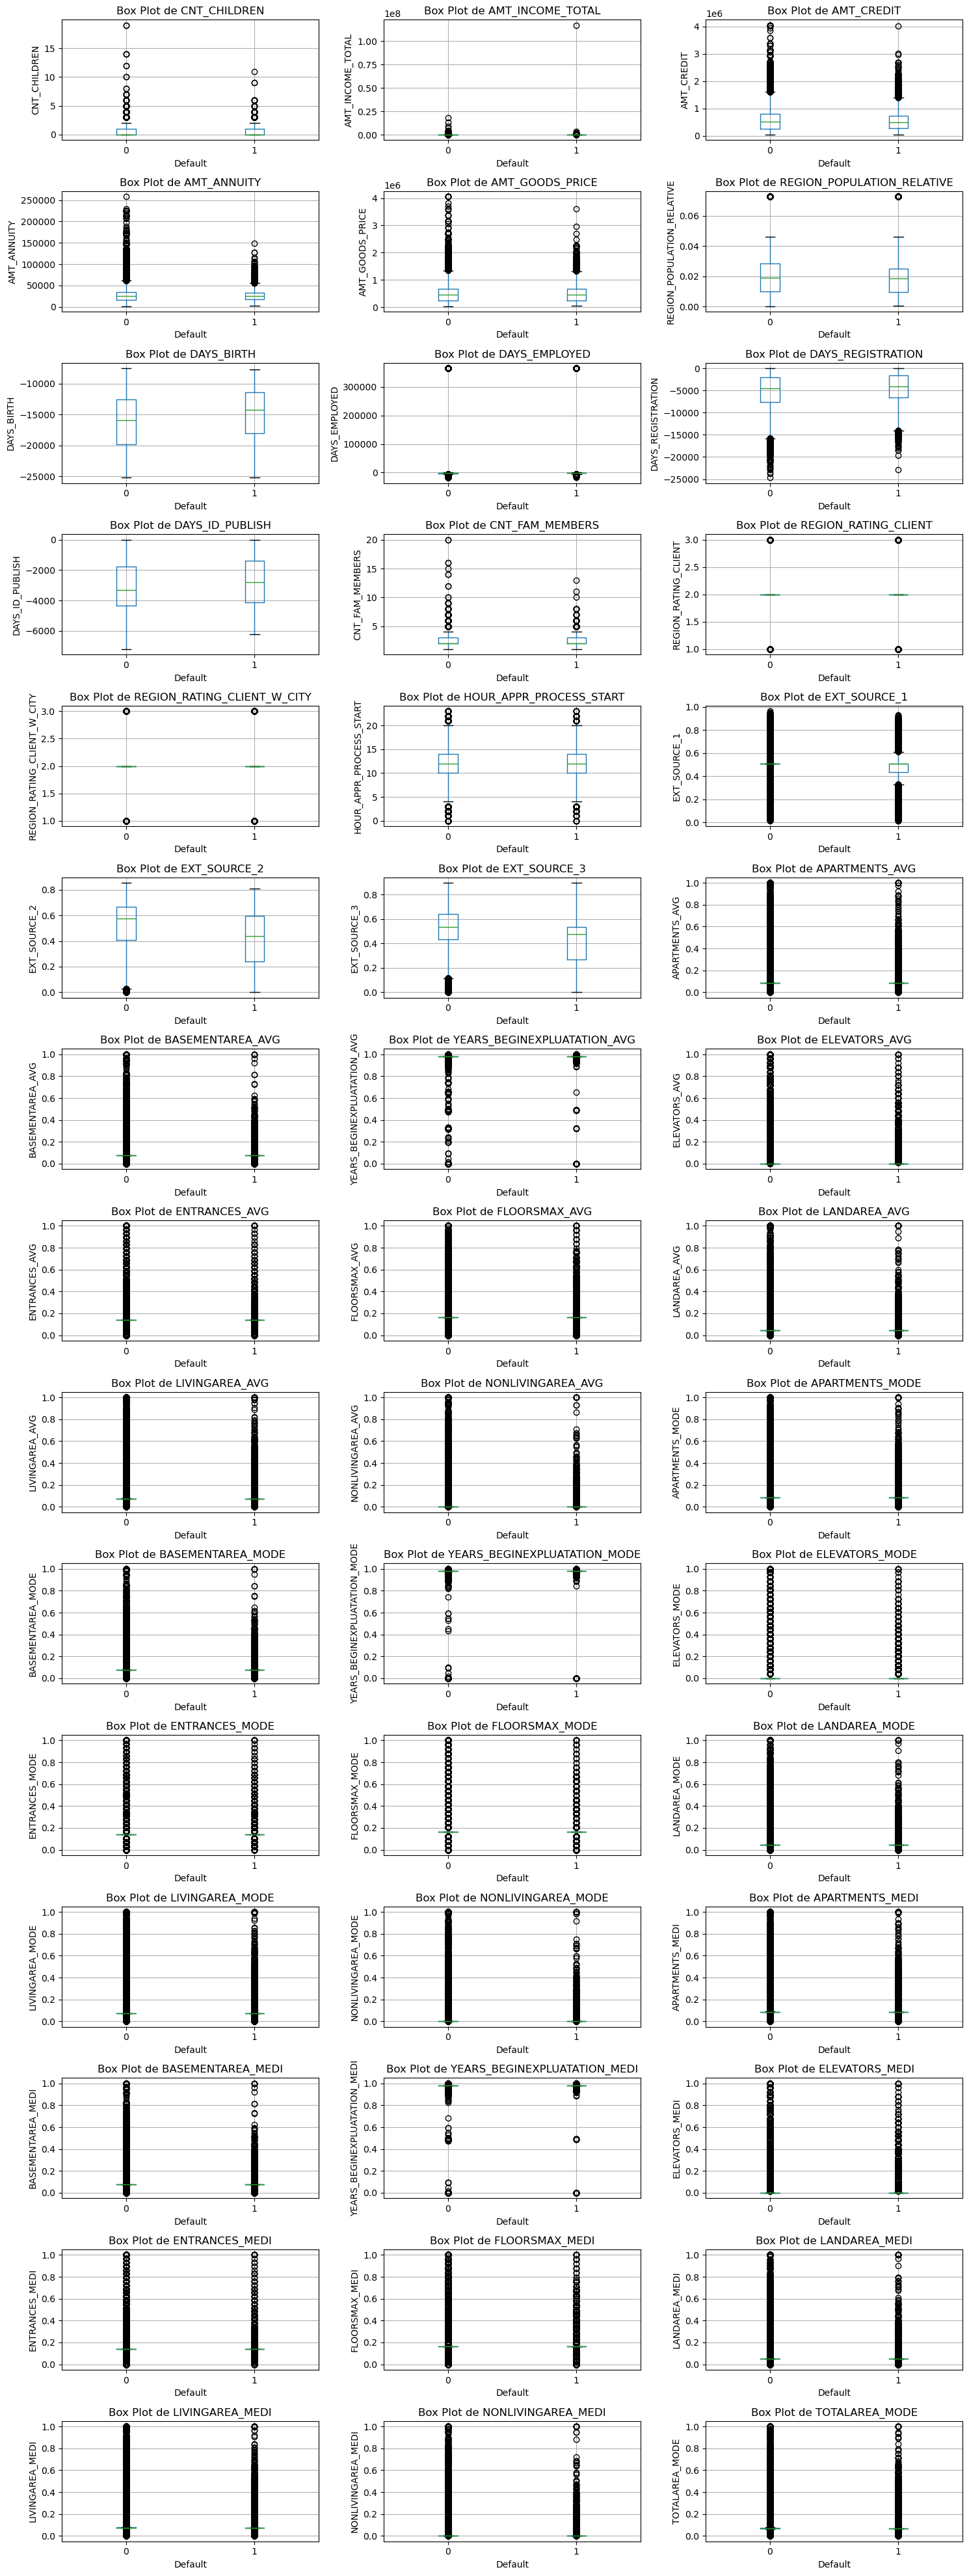

In [34]:
fig, axes = plt.subplots(15, 3, figsize=(15, 40))  # 6 filas y 2 columnas

for i, var in enumerate(numeric_columns):
    if i >= len(axes.flatten()):
        break
    ax = axes.flatten()[i]
    df.boxplot(column=var, by='TARGET', ax=ax)
    ax.set_title(f'Box Plot de {var}')
    ax.set_xlabel('Default')
    ax.set_ylabel(var)

# Eliminar los gráficos vacíos si hay menos de 12 gráficos
if len(numeric_columns) < len(axes.flatten()):
    for j in range(len(numeric_columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('')  # Eliminar el título general que añade pandas por defecto
plt.show()

In [34]:
#numeric_columns

In [35]:
columnas = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

# Iterar sobre cada columna numérica
for columna in columnas:
    # Calcular el percentil 95
    percentil_95 = df[columna].quantile(0.95)
        
    # Reemplazar los valores mayores al percentil 95 por el valor del percentil 95
    df[columna] = df[columna].apply(lambda x: percentil_95 if x > percentil_95 else x)

In [38]:
columnas = ['DAYS_REGISTRATION']

# Iterar sobre cada columna numérica
for columna in columnas:
    # Calcular el percentil 95
    percentil_05 = df[columna].quantile(0.05)
        
    # Reemplazar los valores mayores al percentil 95 por el valor del percentil 95
    df[columna] = df[columna].apply(lambda x: percentil_05 if x < percentil_05 else x)

In [ ]:
columnas = ['DAYS_EMPLOYED']

# Iterar sobre cada columna numérica
for columna in columnas:
    # Calcular el percentil 95
    percentil_75 = df[columna].quantile(0.75)
        
    # Reemplazar los valores mayores al percentil 95 por el valor del percentil 95
    df[columna] = df[columna].apply(lambda x: percentil_75 if x > percentil_75 else x)

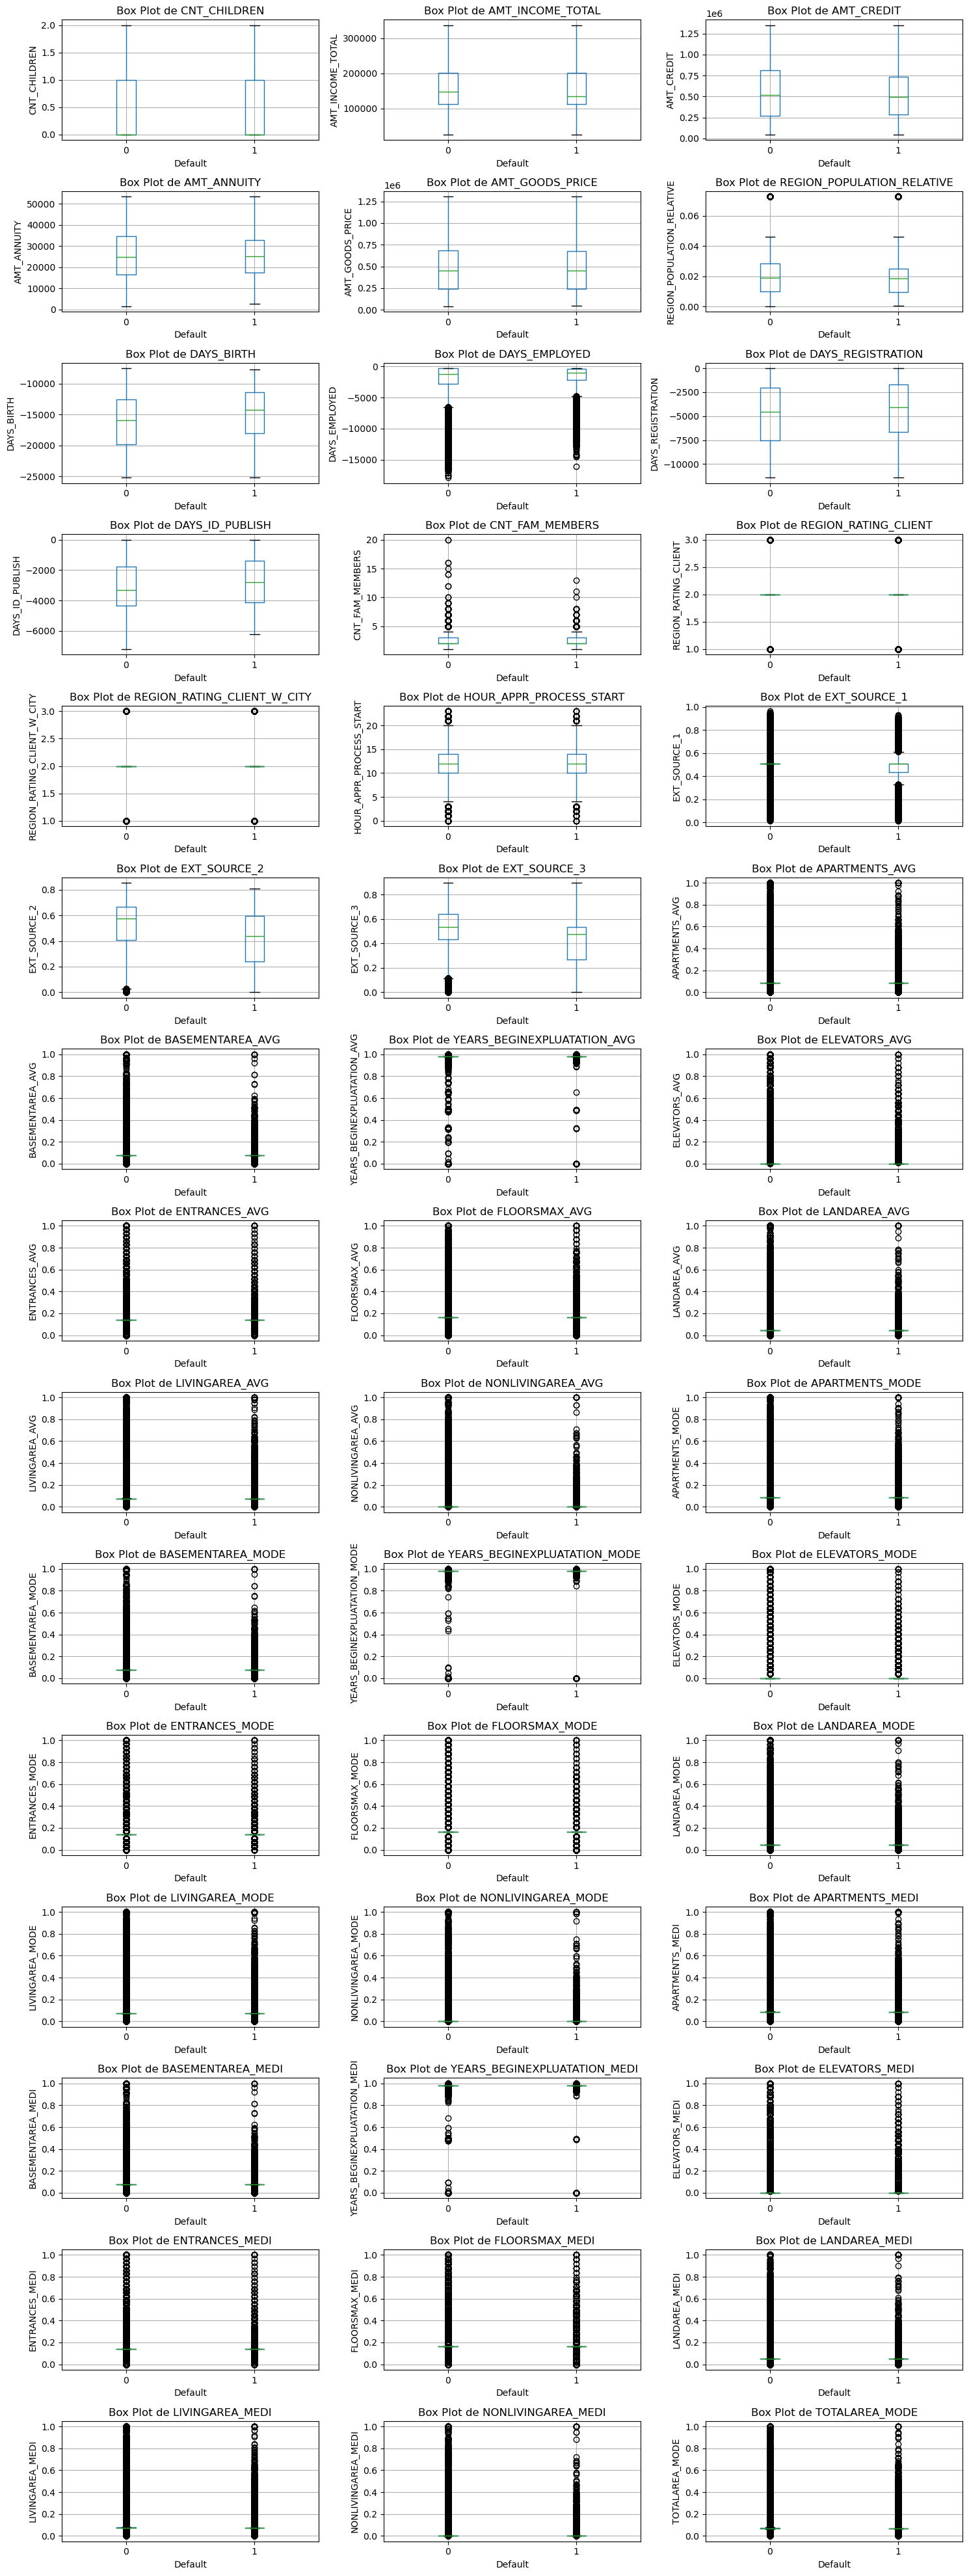

In [50]:
fig, axes = plt.subplots(15, 3, figsize=(15, 40))  # 6 filas y 2 columnas

for i, var in enumerate(numeric_columns):
    if i >= len(axes.flatten()):
        break
    ax = axes.flatten()[i]
    df.boxplot(column=var, by='TARGET', ax=ax)
    ax.set_title(f'Box Plot de {var}')
    ax.set_xlabel('Default')
    ax.set_ylabel(var)

# Eliminar los gráficos vacíos si hay menos de 12 gráficos
if len(numeric_columns) < len(axes.flatten()):
    for j in range(len(numeric_columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('')  # Eliminar el título general que añade pandas por defecto
plt.show()

In [51]:
df.drop('SK_ID_CURR',axis=1,inplace =True)

In [52]:
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.00         202500.00   406597.50     24700.50        351000.00   
1          0.00         270000.00  1293502.50     35698.50       1129500.00   
2          0.00          67500.00   135000.00      6750.00        135000.00   
3          0.00         135000.00   312682.50     29686.50        297000.00   
4          0.00         121500.00   513000.00     21865.50        513000.00   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                N                N                N                N   
1  ...                N                N                N                N   
2  ...                N                N                N                N   
3  ...                N                N                N                N   
4  ...                N                N                N                N   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                       0.00                       0.00   
1                       0.00                       0.00   
2                       0.00                       0.00   
3                       0.00                       0.00   
4                       0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.00                       0.00   
1                        0.00                       0.00   
2                        0.00                       0.00   
3                        0.00                       0.00   
4                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                       0.00                        1.00  
1                       0.00                        0.00  
2                       0.00                        0.00  
3                       0.00                        1.00  
4                       0.00                        0.00  

[5 rows x 104 columns]

In [53]:
df_2 = sc.var_filter(df, y="TARGET")

[INFO] filtering variables ...
Variable filtering on 307511 rows and 104 columns in 00:05:05 
52 variables are removed


In [54]:
# Check categorical variables names
bins = sc.woebin(df_2, y = 'TARGET',save_breaks_list = 'breaks')

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 307511 rows and 52 columns in 00:02:34
[INFO] The breaks_list is saved as breaks_20240621_202015.py


{'LANDAREA_AVG': <Figure size 640x480 with 2 Axes>,
 'FLOORSMAX_MODE': <Figure size 640x480 with 2 Axes>,
 'DAYS_ID_PUBLISH': <Figure size 640x480 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'ELEVATORS_AVG': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'TOTALAREA_MODE': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'NONLIVINGAREA_AVG': <Figure size 640x480 with 2 Axes>,
 'REG_CITY_NOT_LIVE_CITY': <Figure size 640x480 with 2 Axes>,
 'CODE_GENDER': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'YEARS_BEGINEXPLUATATION_AVG': <Figure size 640x480 with 2 Axes>,
 'LIVINGAREA_MODE': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 

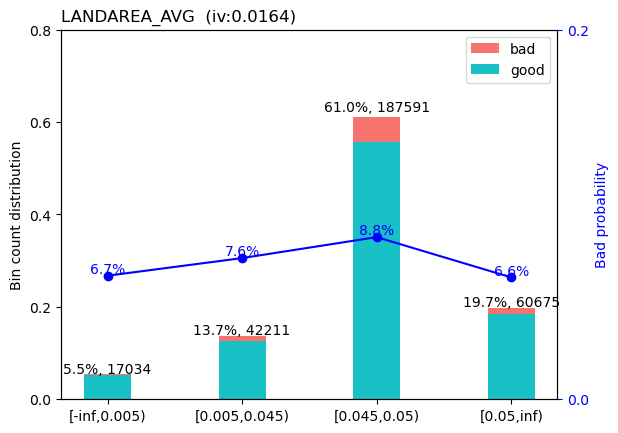

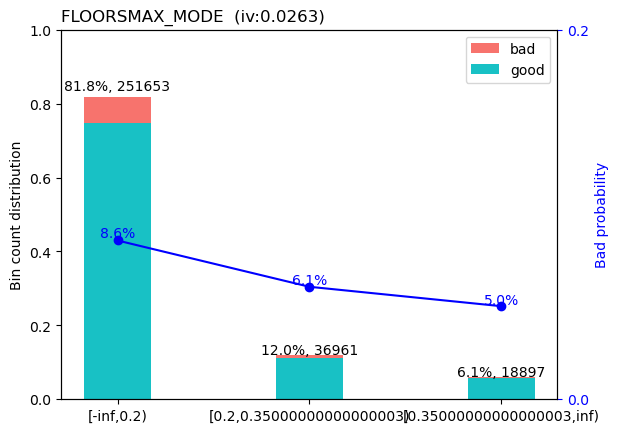

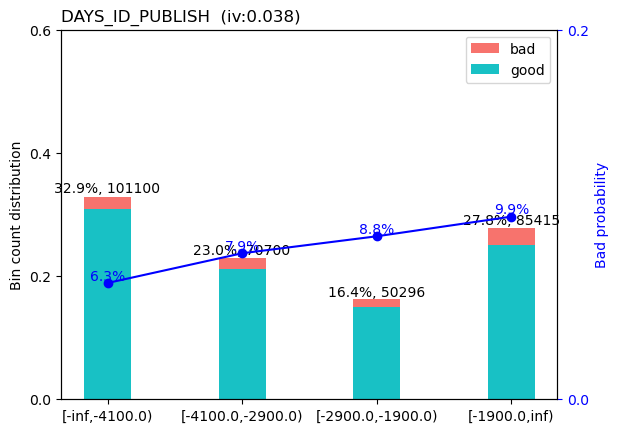

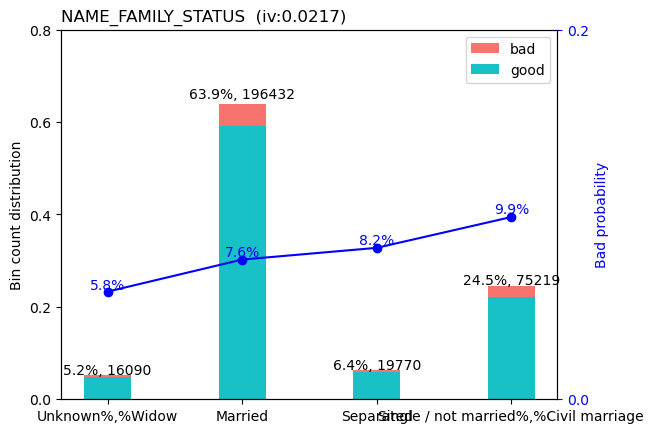

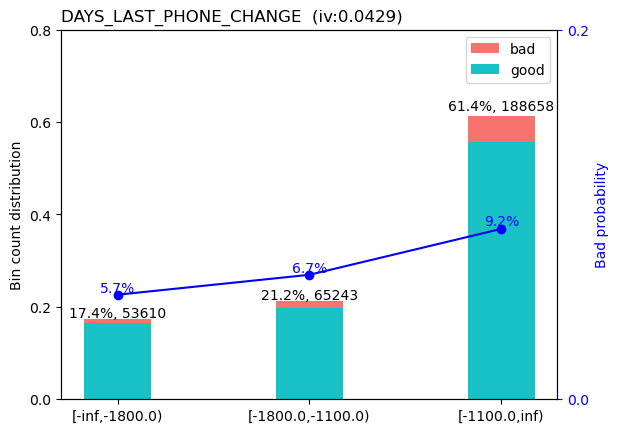

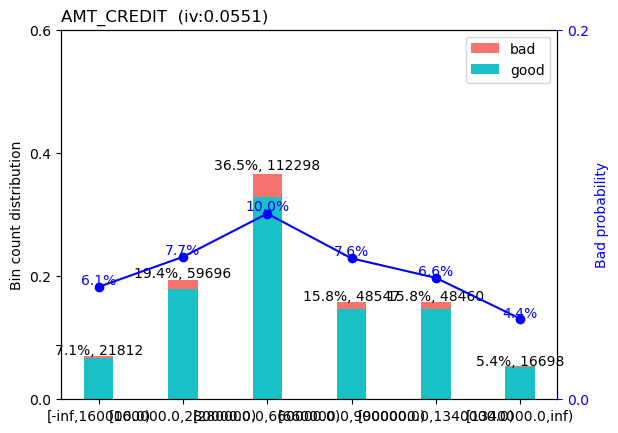

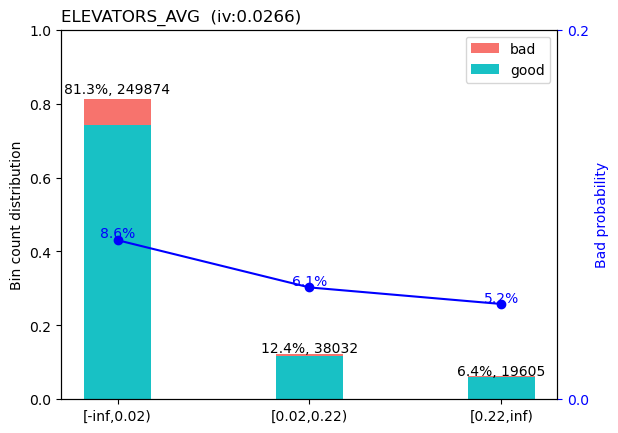

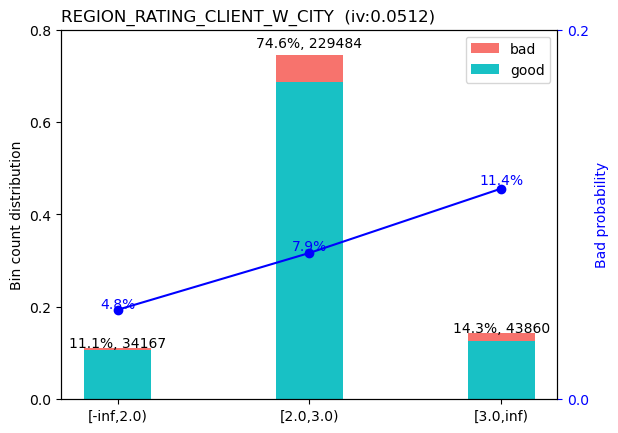

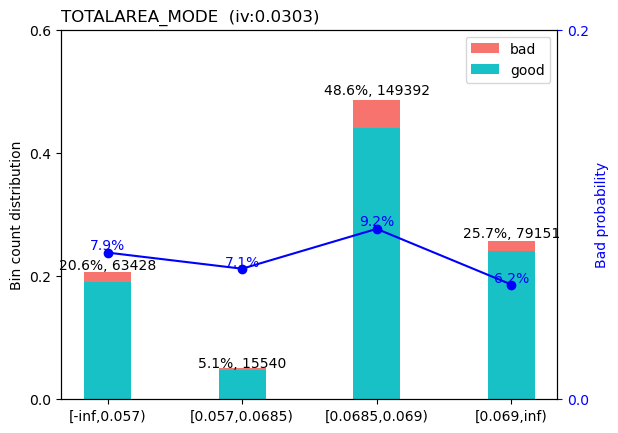

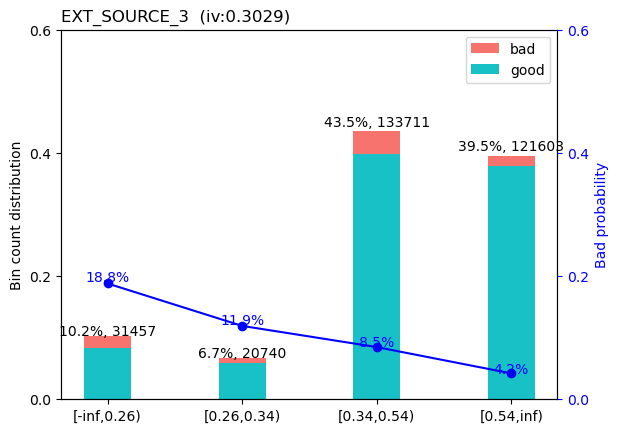

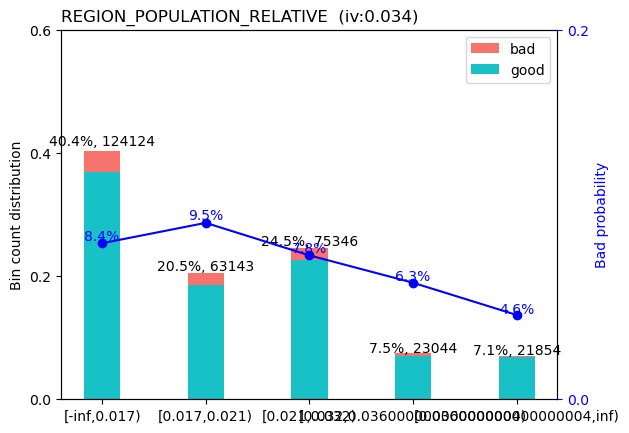

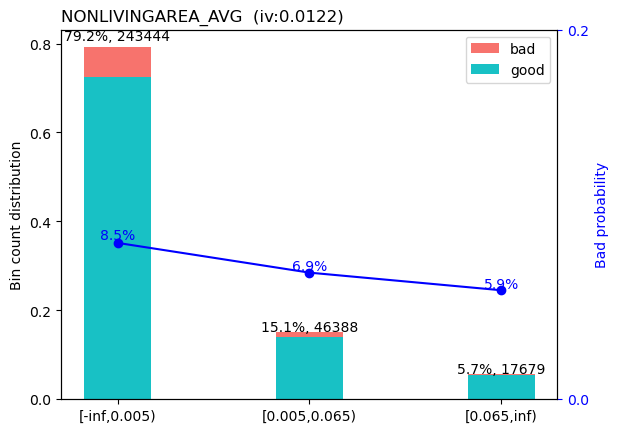

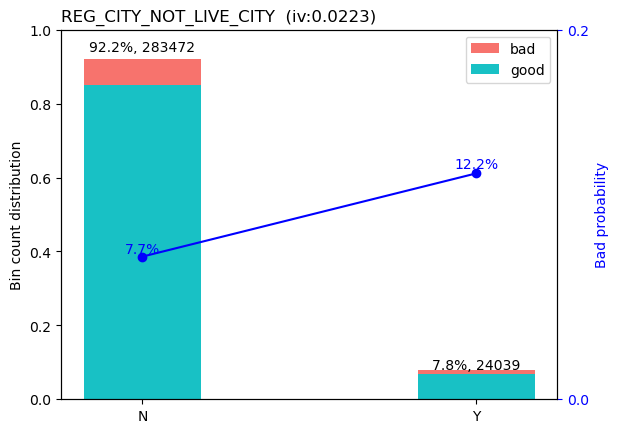

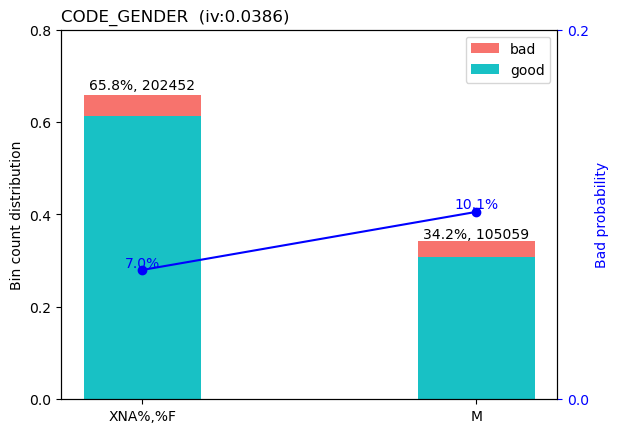

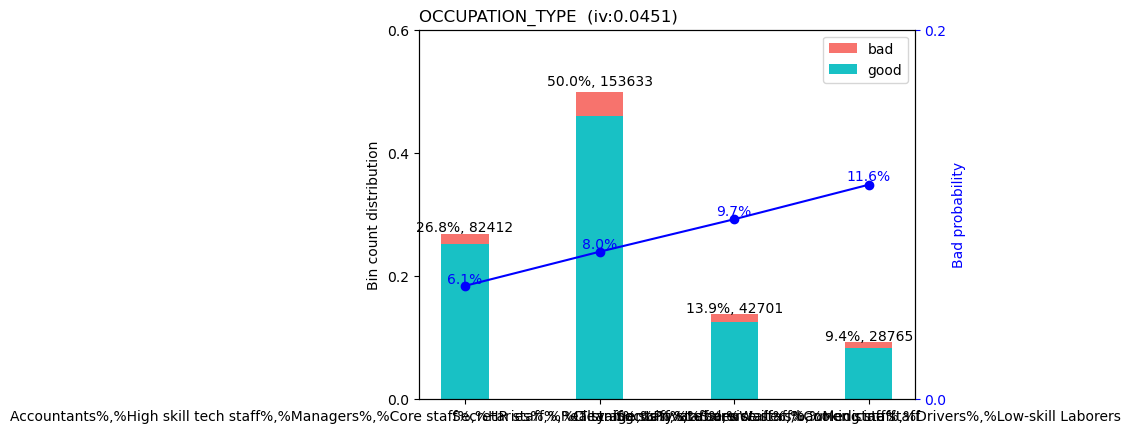

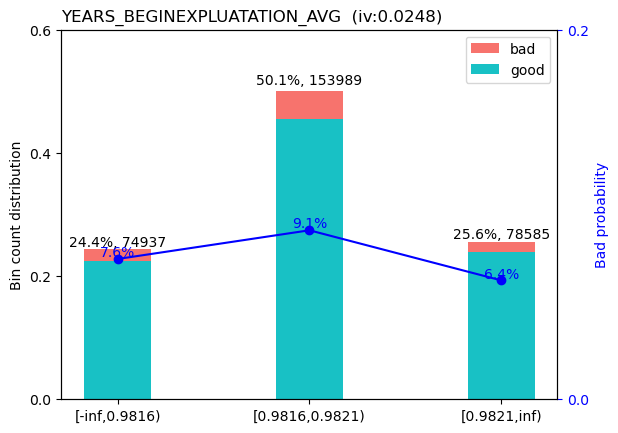

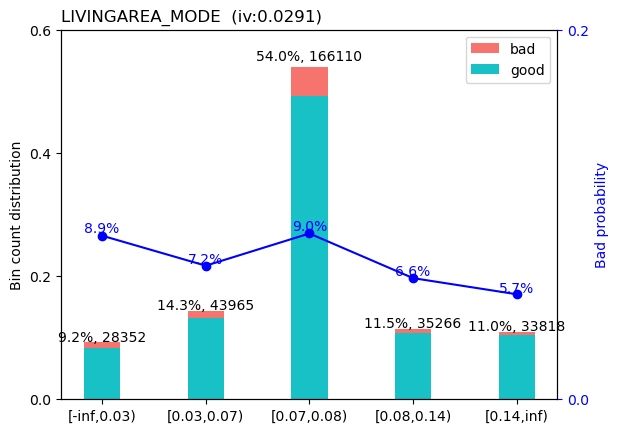

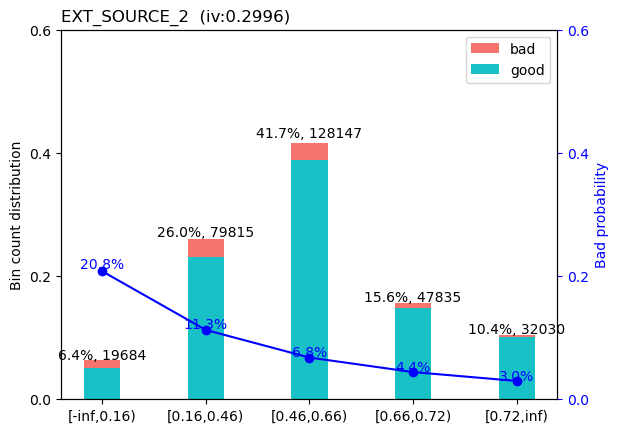

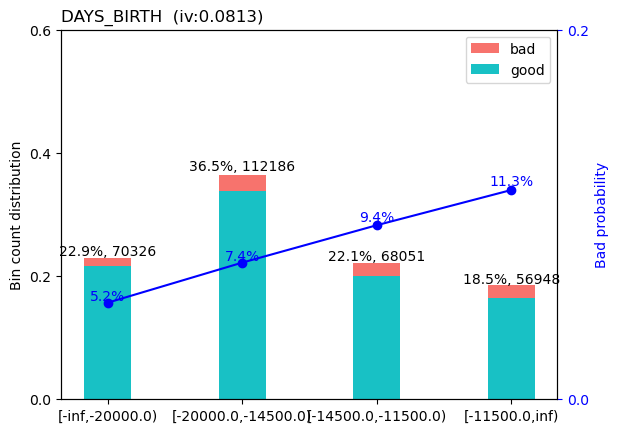

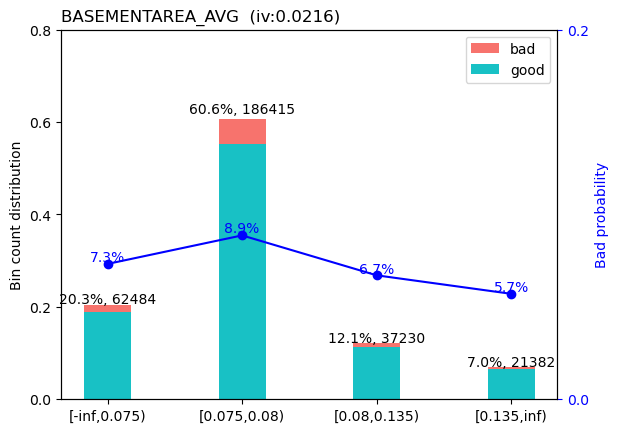

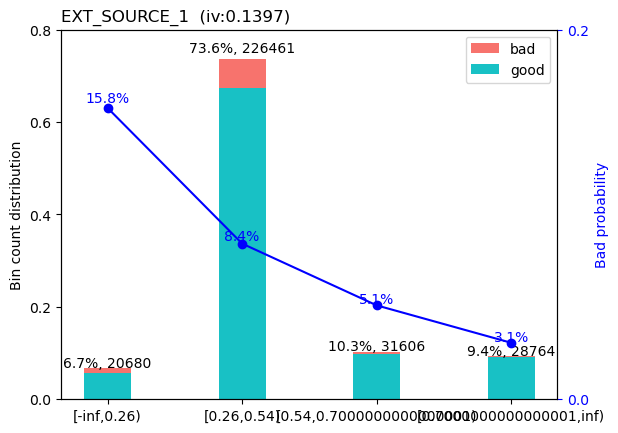

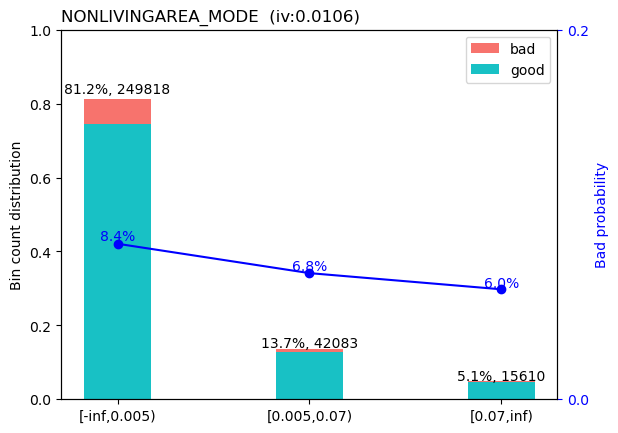

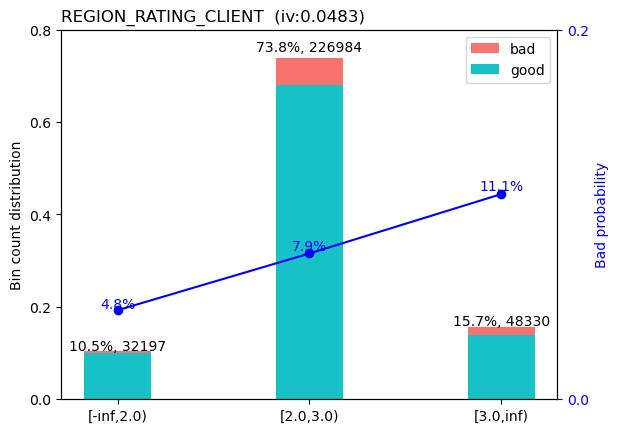

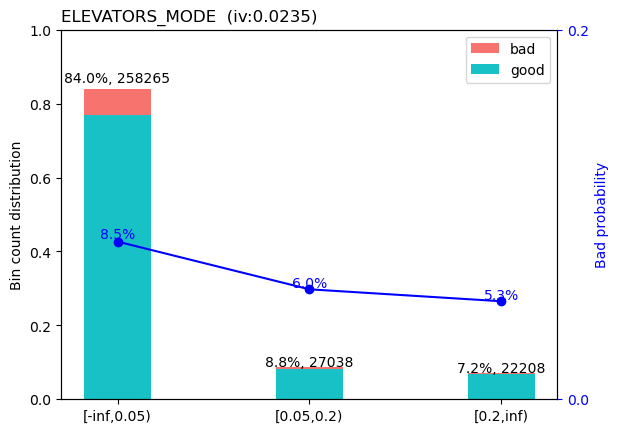

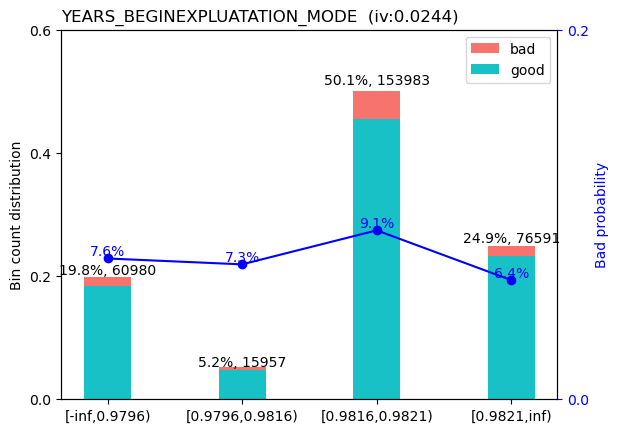

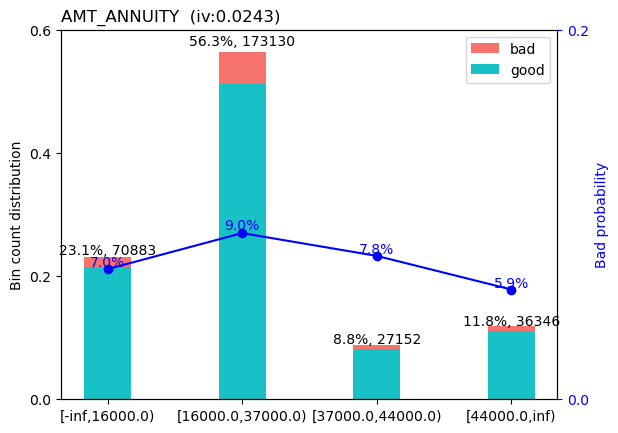

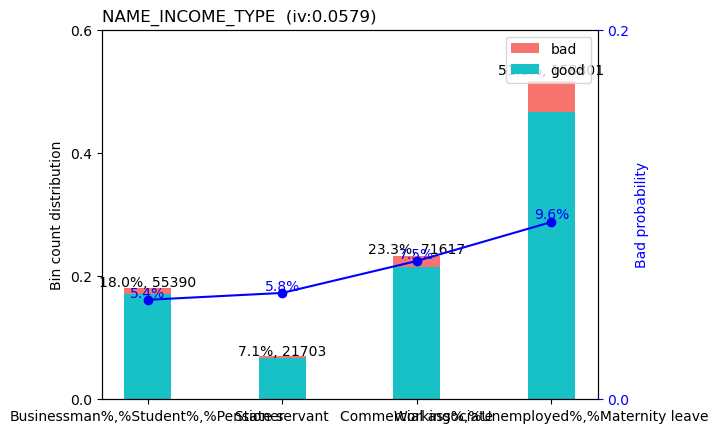

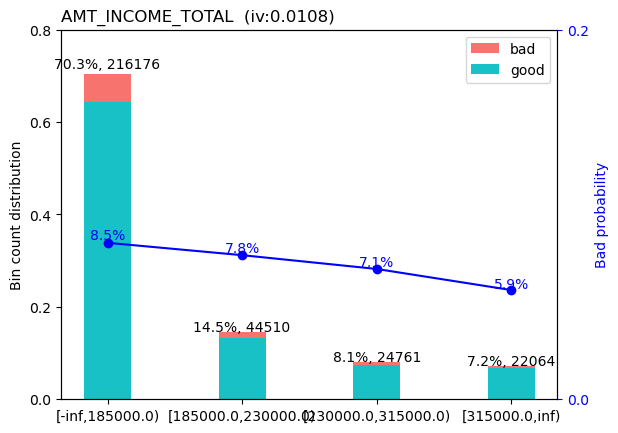

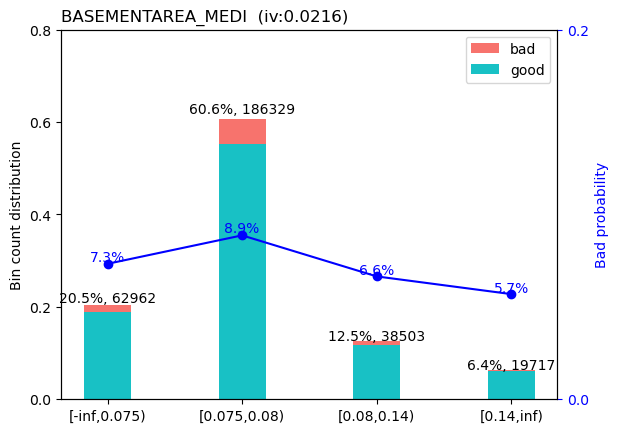

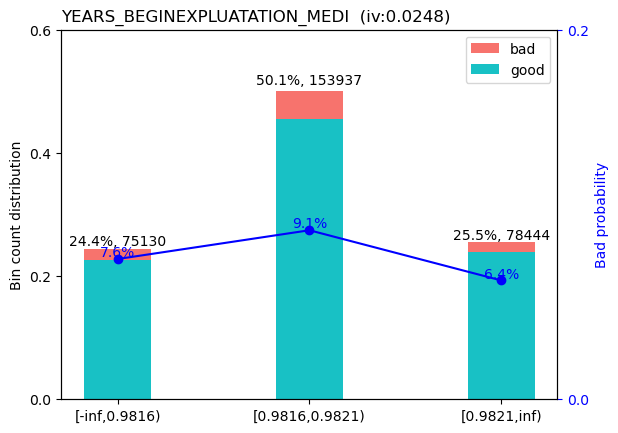

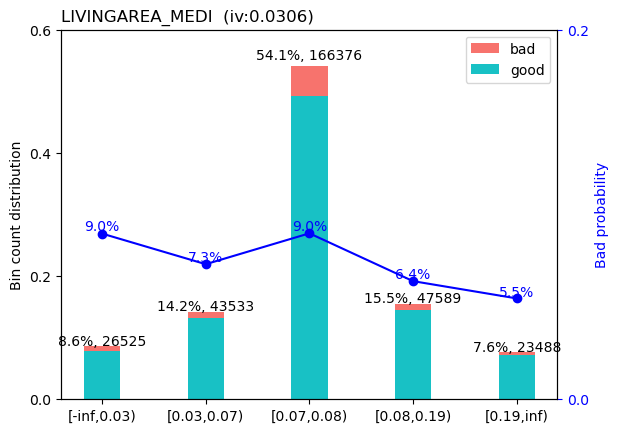

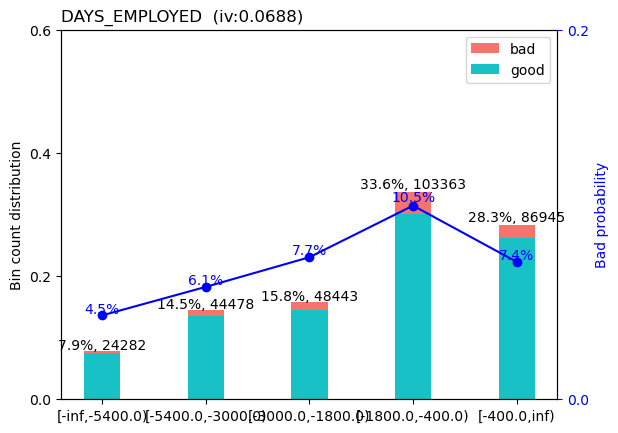

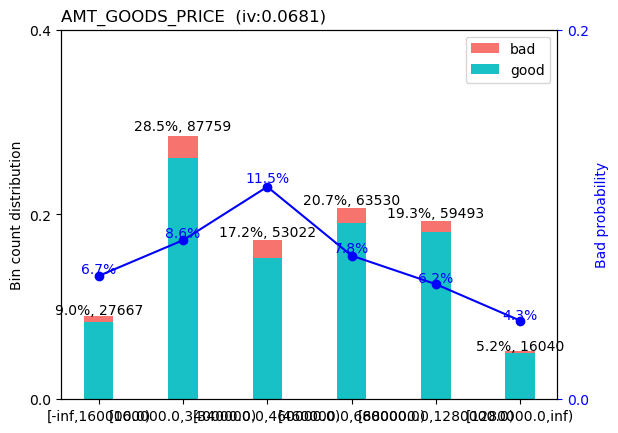

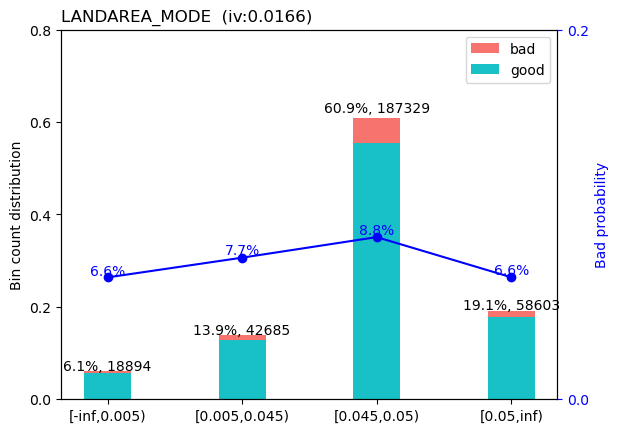

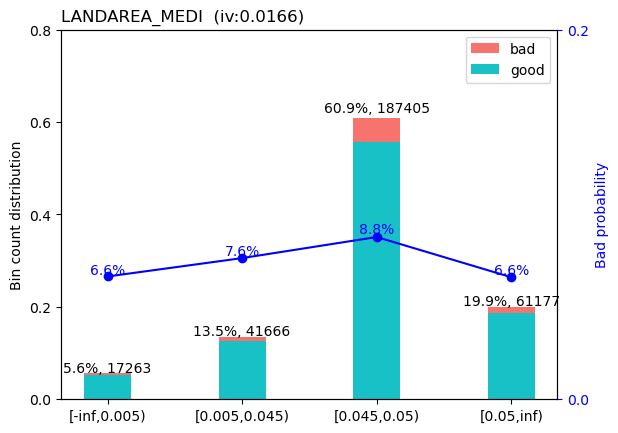

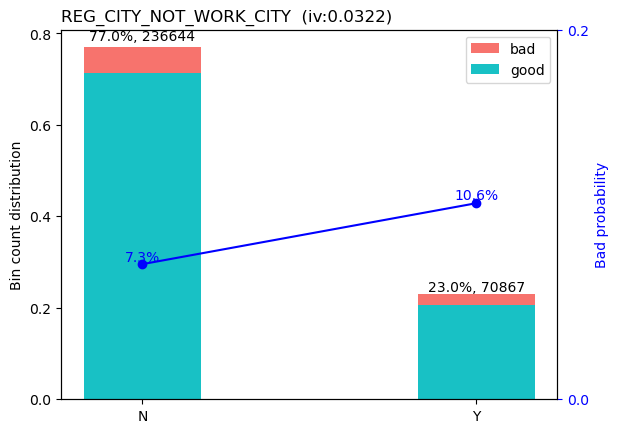

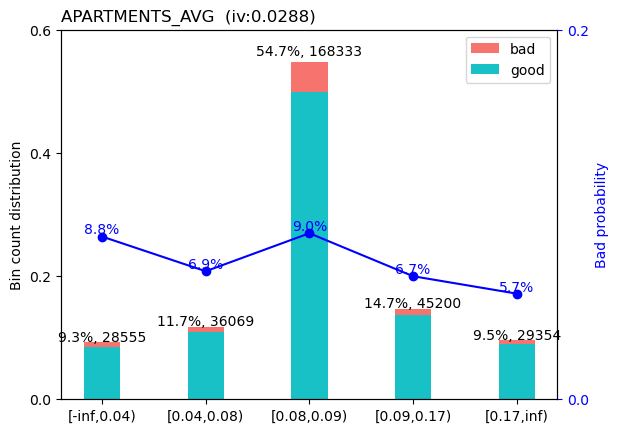

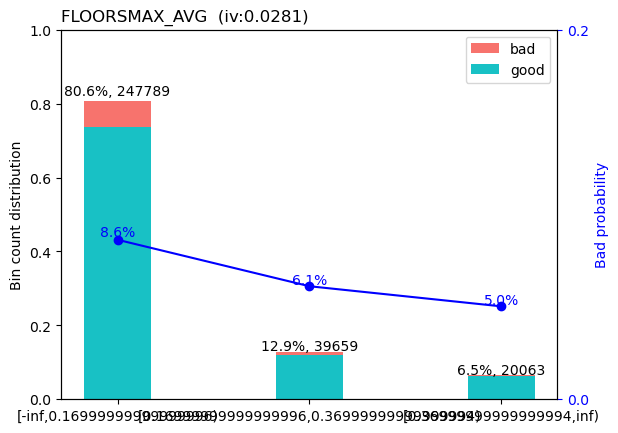

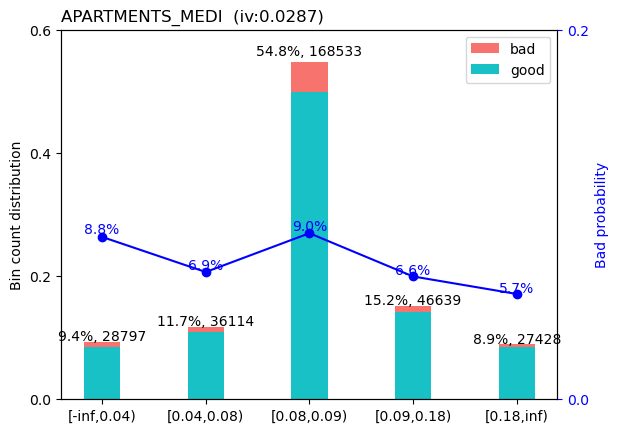

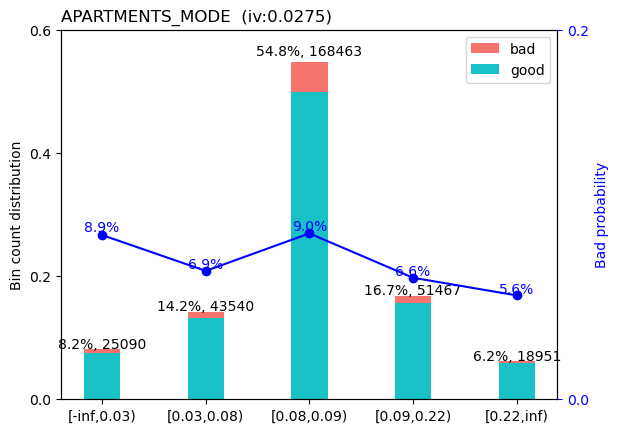

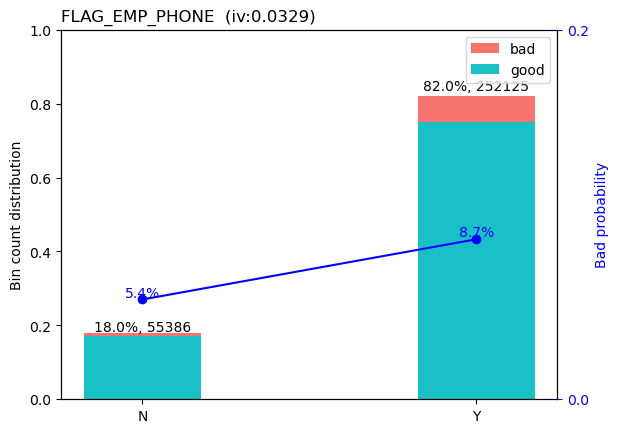

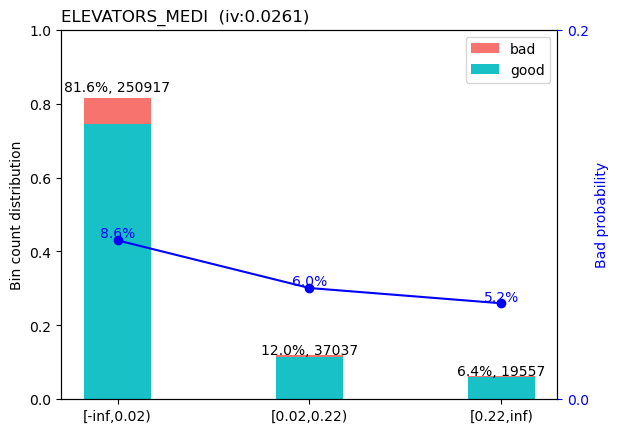

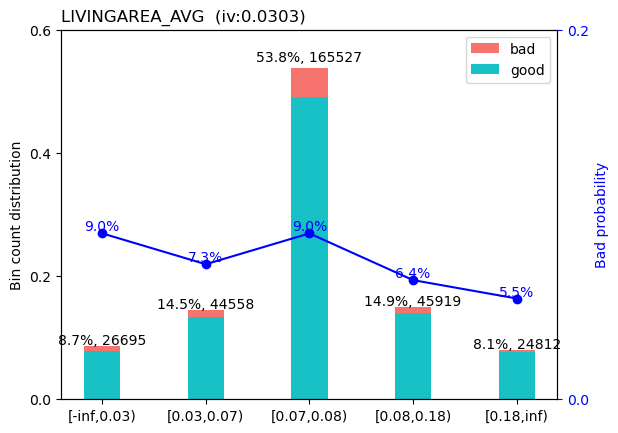

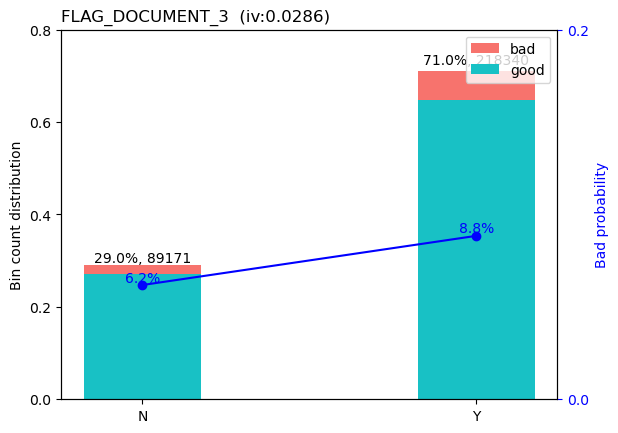

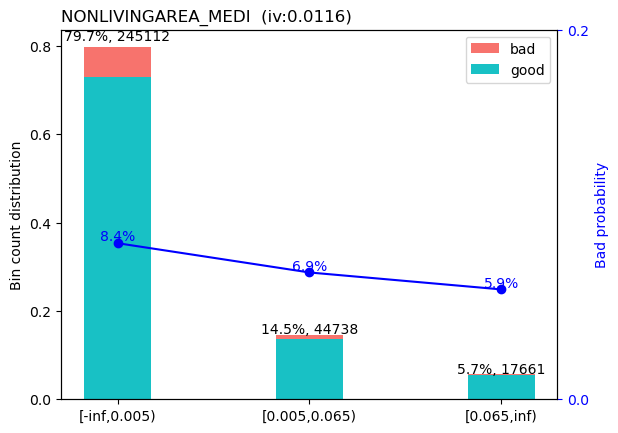

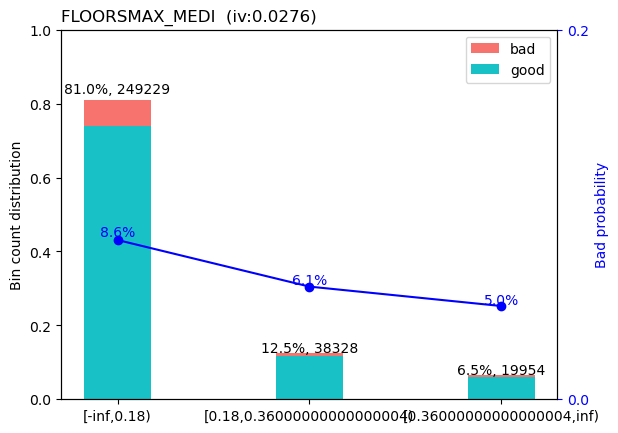

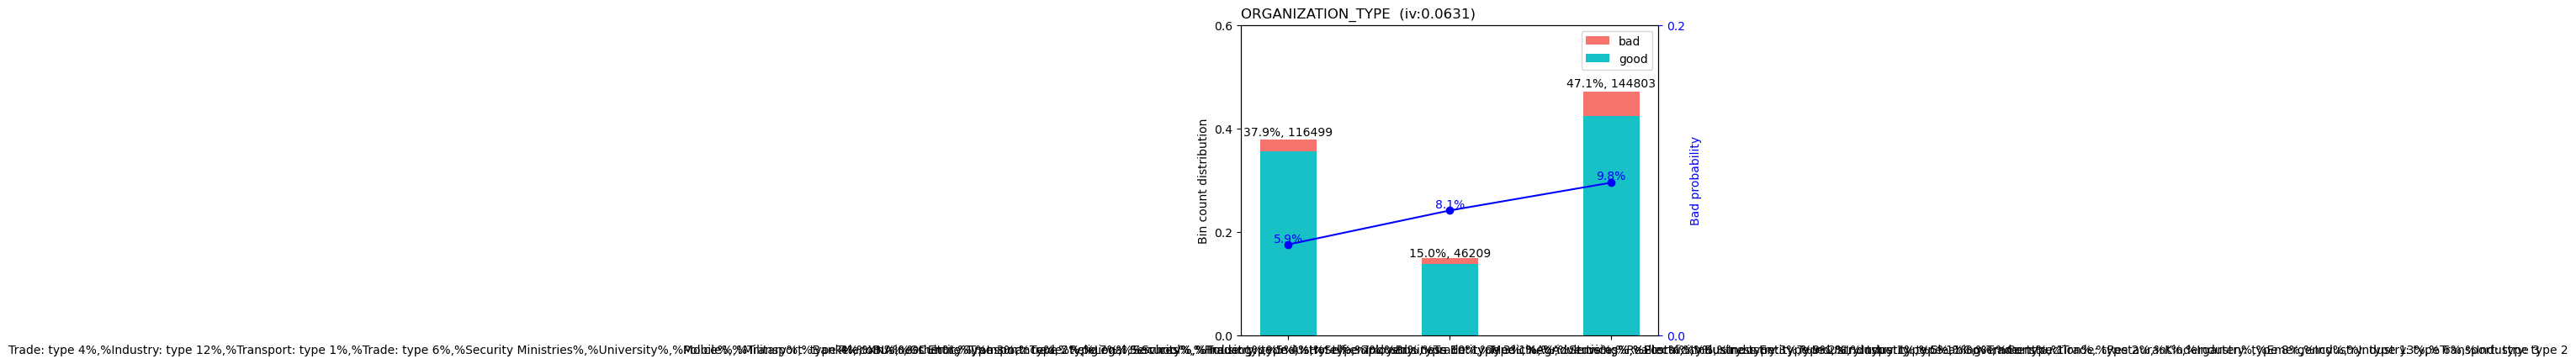

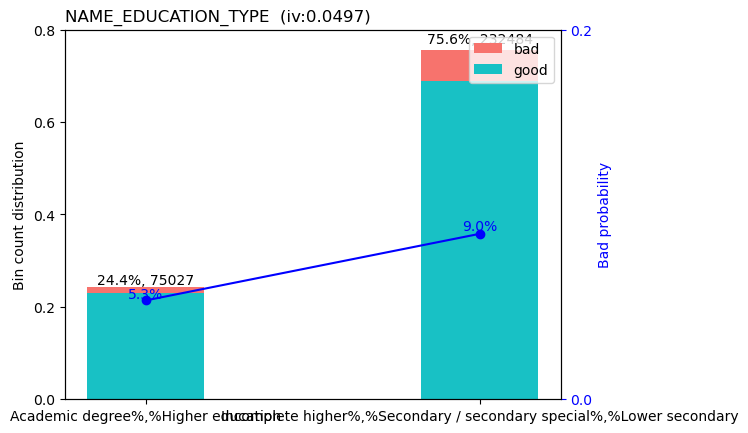

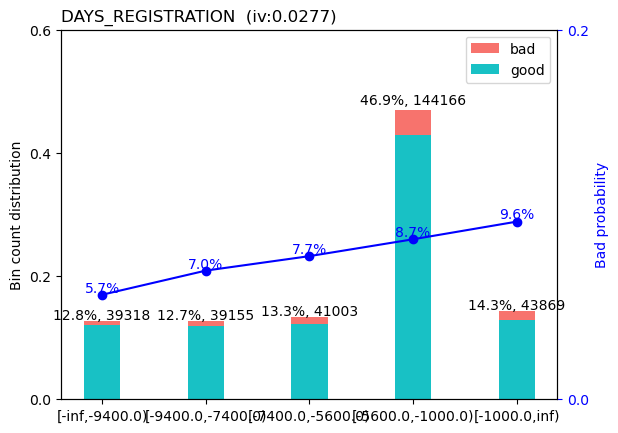

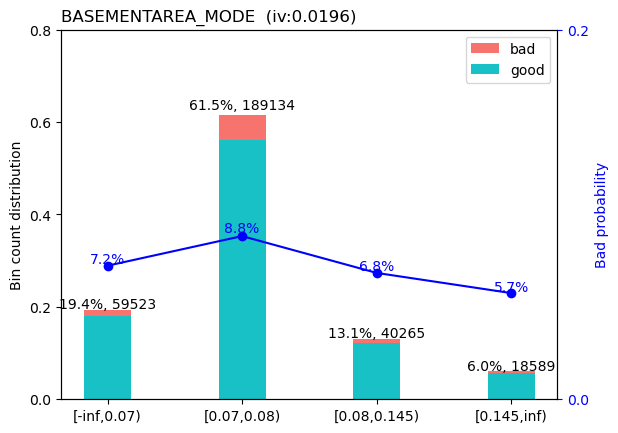

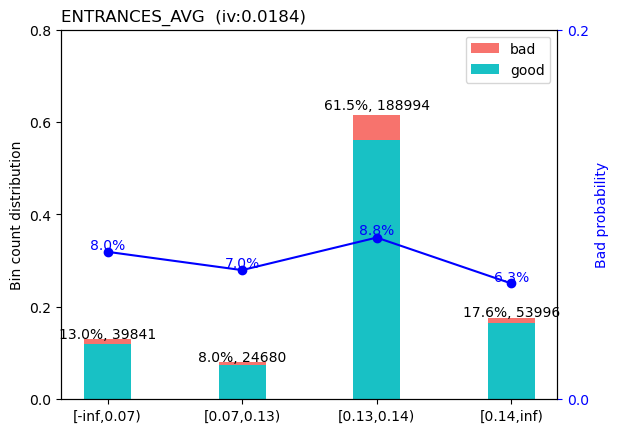

In [55]:
sc.woebin_plot(bins)

In [56]:
# Lista para almacenar los DataFrames individuales
dataframes = []

# Extraer las columnas 'variable' y 'total_iv' de cada DataFrame y agregarlas a la lista
for key in bins:
    df = bins[key][['variable', 'total_iv']]
    dataframes.append(df)

# Concatenar todos los DataFrames
combined_df = pd.concat(dataframes)

# Eliminar filas duplicadas
unique_df = combined_df.drop_duplicates()
unique_df= unique_df.sort_values(by='total_iv',ascending=False)

In [57]:
unique_df

variable  total_iv
0                  EXT_SOURCE_3      0.30
0                  EXT_SOURCE_2      0.30
0                  EXT_SOURCE_1      0.14
0                    DAYS_BIRTH      0.08
0                 DAYS_EMPLOYED      0.07
0               AMT_GOODS_PRICE      0.07
0             ORGANIZATION_TYPE      0.06
0              NAME_INCOME_TYPE      0.06
0                    AMT_CREDIT      0.06
0   REGION_RATING_CLIENT_W_CITY      0.05
0           NAME_EDUCATION_TYPE      0.05
0          REGION_RATING_CLIENT      0.05
0               OCCUPATION_TYPE      0.05
0        DAYS_LAST_PHONE_CHANGE      0.04
0                   CODE_GENDER      0.04
0               DAYS_ID_PUBLISH      0.04
0    REGION_POPULATION_RELATIVE      0.03
0                FLAG_EMP_PHONE      0.03
0        REG_CITY_NOT_WORK_CITY      0.03
0               LIVINGAREA_MEDI      0.03
0                LIVINGAREA_AVG      0.03
0                TOTALAREA_MODE      0.03
0               LIVINGAREA_MODE      0.03
0                APARTMENTS_AVG      0.03
0               APARTMENTS_MEDI      0.03
0               FLAG_DOCUMENT_3      0.03
0                 FLOORSMAX_AVG      0.03
0             DAYS_REGISTRATION      0.03
0                FLOORSMAX_MEDI      0.03
0               APARTMENTS_MODE      0.03
0                 ELEVATORS_AVG      0.03
0                FLOORSMAX_MODE      0.03
0                ELEVATORS_MEDI      0.03
0  YEARS_BEGINEXPLUATATION_MEDI      0.02
0   YEARS_BEGINEXPLUATATION_AVG      0.02
0  YEARS_BEGINEXPLUATATION_MODE      0.02
0                   AMT_ANNUITY      0.02
0                ELEVATORS_MODE      0.02
0        REG_CITY_NOT_LIVE_CITY      0.02
0            NAME_FAMILY_STATUS      0.02
0             BASEMENTAREA_MEDI      0.02
0              BASEMENTAREA_AVG      0.02
0             BASEMENTAREA_MODE      0.02
0                 ENTRANCES_AVG      0.02
0                 LANDAREA_MEDI      0.02
0                 LANDAREA_MODE      0.02
0                  LANDAREA_AVG      0.02
0             NONLIVINGAREA_AVG      0.01
0            NONLIVINGAREA_MEDI      0.01
0              AMT_INCOME_TOTAL      0.01
0            NONLIVINGAREA_MODE      0.01

In [82]:
#drop_columns = list(unique_df[unique_df['total_iv']<0.02].variable)

In [83]:
#df_train.drop(drop_columns,axis=1,inplace=True)

In [58]:
## Breaking dt into train and test ##
train, test = sc.split_df(df_2, 'TARGET').values()

In [59]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
Woe transformating on 215258 rows and 51 columns in 00:00:44
[INFO] converting into woe values ...
Woe transformating on 92253 rows and 51 columns in 00:00:19


In [60]:
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

In [61]:
## Over sampling by SMOTE ##
X_res,y_res = oversampling_by_smote(X_train,y_train)

Resampled dataset shape Counter({1: 197880, 0: 197880})


In [62]:
## Logistic regression model ##
lr = LogisticRegression(solver="lbfgs")
#lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_res, y_res)

LogisticRegression()

In [63]:
## predict proability from LR model ##
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

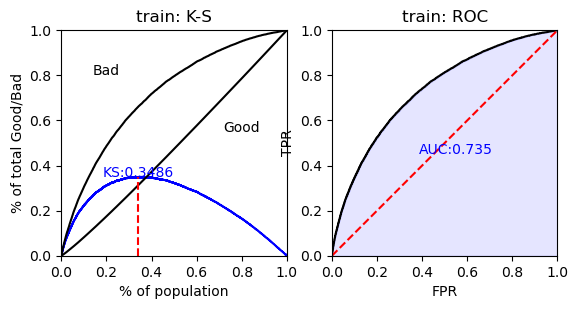

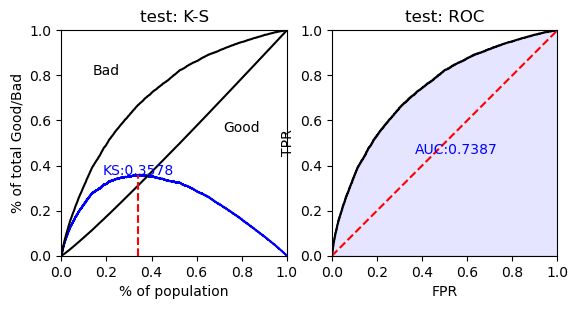

In [64]:
## Plot model performance(ks & roc) ##
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [65]:
predictions = lr.predict(X_test)

In [66]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     84806
           1       0.17      0.62      0.26      7447

    accuracy                           0.72     92253
   macro avg       0.56      0.68      0.54     92253
weighted avg       0.89      0.72      0.78     92253



In [67]:
conf_log2 = confusion_matrix(y_test,predictions)
conf_log2

array([[61683, 23123],
       [ 2805,  4642]], dtype=int64)

In [68]:
## Get score card ##
card = sc.scorecard(bins, lr, X_train.columns)
card = pd.concat(card.values())
card.reset_index(drop=True, inplace=True)
card

variable  \
0                      basepoints   
1                    LANDAREA_AVG   
2                    LANDAREA_AVG   
3                    LANDAREA_AVG   
4                    LANDAREA_AVG   
5                  FLOORSMAX_MODE   
6                  FLOORSMAX_MODE   
7                  FLOORSMAX_MODE   
8                 DAYS_ID_PUBLISH   
9                 DAYS_ID_PUBLISH   
10                DAYS_ID_PUBLISH   
11                DAYS_ID_PUBLISH   
12             NAME_FAMILY_STATUS   
13             NAME_FAMILY_STATUS   
14             NAME_FAMILY_STATUS   
15             NAME_FAMILY_STATUS   
16         DAYS_LAST_PHONE_CHANGE   
17         DAYS_LAST_PHONE_CHANGE   
18         DAYS_LAST_PHONE_CHANGE   
19                     AMT_CREDIT   
20                     AMT_CREDIT   
21                     AMT_CREDIT   
22                     AMT_CREDIT   
23                     AMT_CREDIT   
24                     AMT_CREDIT   
25                  ELEVATORS_AVG   
26                  ELEVATORS_AVG   
27                  ELEVATORS_AVG   
28    REGION_RATING_CLIENT_W_CITY   
29    REGION_RATING_CLIENT_W_CITY   
30    REGION_RATING_CLIENT_W_CITY   
31                 TOTALAREA_MODE   
32                 TOTALAREA_MODE   
33                 TOTALAREA_MODE   
34                 TOTALAREA_MODE   
35                   EXT_SOURCE_3   
36                   EXT_SOURCE_3   
37                   EXT_SOURCE_3   
38                   EXT_SOURCE_3   
39     REGION_POPULATION_RELATIVE   
40     REGION_POPULATION_RELATIVE   
41     REGION_POPULATION_RELATIVE   
42     REGION_POPULATION_RELATIVE   
43     REGION_POPULATION_RELATIVE   
44              NONLIVINGAREA_AVG   
45              NONLIVINGAREA_AVG   
46              NONLIVINGAREA_AVG   
47         REG_CITY_NOT_LIVE_CITY   
48         REG_CITY_NOT_LIVE_CITY   
49                    CODE_GENDER   
50                    CODE_GENDER   
51                OCCUPATION_TYPE   
52                OCCUPATION_TYPE   
53                OCCUPATION_TYPE   
54                OCCUPATION_TYPE   
55    YEARS_BEGINEXPLUATATION_AVG   
56    YEARS_BEGINEXPLUATATION_AVG   
57    YEARS_BEGINEXPLUATATION_AVG   
58                LIVINGAREA_MODE   
59                LIVINGAREA_MODE   
60                LIVINGAREA_MODE   
61                LIVINGAREA_MODE   
62                LIVINGAREA_MODE   
63                   EXT_SOURCE_2   
64                   EXT_SOURCE_2   
65                   EXT_SOURCE_2   
66                   EXT_SOURCE_2   
67                   EXT_SOURCE_2   
68                     DAYS_BIRTH   
69                     DAYS_BIRTH   
70                     DAYS_BIRTH   
71                     DAYS_BIRTH   
72               BASEMENTAREA_AVG   
73               BASEMENTAREA_AVG   
74               BASEMENTAREA_AVG   
75               BASEMENTAREA_AVG   
76                   EXT_SOURCE_1   
77                   EXT_SOURCE_1   
78                   EXT_SOURCE_1   
79                   EXT_SOURCE_1   
80             NONLIVINGAREA_MODE   
81             NONLIVINGAREA_MODE   
82             NONLIVINGAREA_MODE   
83           REGION_RATING_CLIENT   
84           REGION_RATING_CLIENT   
85           REGION_RATING_CLIENT   
86                 ELEVATORS_MODE   
87                 ELEVATORS_MODE   
88                 ELEVATORS_MODE   
89   YEARS_BEGINEXPLUATATION_MODE   
90   YEARS_BEGINEXPLUATATION_MODE   
91   YEARS_BEGINEXPLUATATION_MODE   
92   YEARS_BEGINEXPLUATATION_MODE   
93                    AMT_ANNUITY   
94                    AMT_ANNUITY   
95                    AMT_ANNUITY   
96                    AMT_ANNUITY   
97               NAME_INCOME_TYPE   
98               NAME_INCOME_TYPE   
99               NAME_INCOME_TYPE   
100              NAME_INCOME_TYPE   
101              AMT_INCOME_TOTAL   
102              AMT_INCOME_TOTAL   
103              AMT_INCOME_TOTAL   
104              AMT_INCOME_TOTAL   
105             BASEMENTAREA_MEDI   
106             BASEMENTAREA_MEDI   
107             BASEMENTAREA_

In [69]:
## Show credit score(train/test/good/bad) ##
data_gc_score      = sc.scorecard_ply(df_2,card,print_step=0)
train_score        = sc.scorecard_ply(train, card, print_step=0)
test_score         = sc.scorecard_ply(test, card, print_step=0)
test_score_all_var = sc.scorecard_ply(test, card, print_step=0,only_total_score=False)
score_with_target  = pd.concat([data_gc_score,df_2['TARGET']],axis=1)
score_total        = score_with_target['score']
score_good         = score_with_target[score_with_target.TARGET == 0]['score']
score_bad          = score_with_target[score_with_target.TARGET==1]['score']

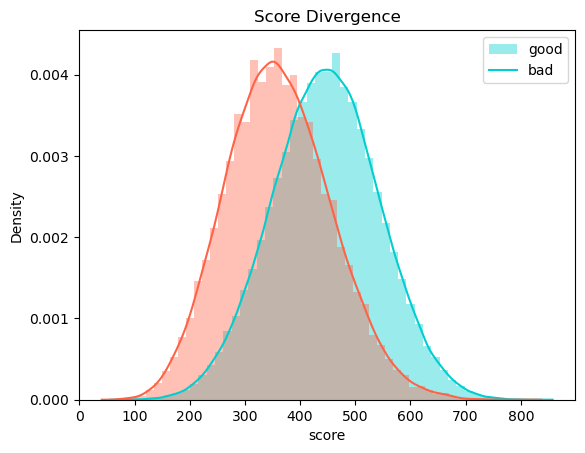

In [70]:
## Plot Score Divergence(good/bad) ##
plot_score_distribution(score_good,score_bad,'good','bad','Score Divergence')

In [71]:
## Show score sorting ##
score_bin_sort = score_bin_sort(
    score = {'train':train_score, 'test':test_score},
    label = {'train':y_train, 'test':y_test}
)
score_bin_sort.sort_values(by='bad rate%',ascending=False).style.bar(color='tomato',subset='bad rate%')

In [72]:
test_score_all_var.head()

LANDAREA_AVG_points  FLOORSMAX_MODE_points  DAYS_ID_PUBLISH_points  \
3                  4.00                   4.00                   -3.00   
5                  4.00                   4.00                   -6.00   
9                  4.00                   4.00                    1.00   
11                 4.00                   4.00                   -3.00   
13                -9.00                 -18.00                    8.00   

    NAME_FAMILY_STATUS_points  DAYS_LAST_PHONE_CHANGE_points  \
3                       -3.00                          -7.00   
5                        1.00                          18.00   
9                       -3.00                           9.00   
11                       1.00                          18.00   
13                       1.00                          -7.00   

    AMT_CREDIT_points  ELEVATORS_AVG_points  \
3               -2.00                 -3.00   
5               -2.00                 -3.00   
9               -2.00                 -3.00   
11               3.00                 -3.00   
13               2.00                 11.00   

    REGION_RATING_CLIENT_W_CITY_points  TOTALAREA_MODE_points  \
3                                 1.00                  -7.00   
5                                 1.00                  -7.00   
9                                 1.00                  -7.00   
11                                1.00                  -7.00   
13                                1.00                  13.00   

    EXT_SOURCE_3_points  ...  LIVINGAREA_AVG_points  FLAG_DOCUMENT_3_points  \
3                 -4.00  ...                  -0.00                   -9.00   
5                 59.00  ...                  -0.00                   -9.00   
9                 -4.00  ...                  -0.00                   26.00   
11                59.00  ...                  -0.00                   26.00   
13                59.00  ...                   0.00                   -9.00   

    NONLIVINGAREA_MEDI_points  FLOORSMAX_MEDI_points  \
3                        1.00                  -2.00   
5                        1.00                  -2.00   
9                        1.00                  -2.00   
11                       1.00                  -2.00   
13                       1.00                   9.00   

    ORGANIZATION_TYPE_points  NAME_EDUCATION_TYPE_points  \
3                     -14.00                       -9.00   
5                       0.00                       -9.00   
9                      22.00                       -9.00   
11                     22.00                       -9.00   
13                    -14.00                       -9.00   

    DAYS_REGISTRATION_points  BASEMENTAREA_MODE_points  ENTRANCES_AVG_points  \
3                      20.00                      1.00                 -3.00   
5                      -4.00                      1.00                 -3.00   
9                      20.00                      1.00                 -3.00   
11                     -4.00                      1.00                 -3.00   
13                    -10.00                     -2.00                 -3.00   

    score  
3  384.00  
5  391.00  
9  494.00  
11 594.00  
13 418.00  

[5 rows x 52 columns]